## Import modules

In [31]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import statsmodels.formula.api as smformula
from sklearn.preprocessing import scale
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Load the combined dataset and inspect it

In [32]:
os.chdir('C:\Apurva\Conservation Games\Games meta-analysis\Datasets\Data Gabon, Orkney, Madagascar and Kenya')
print(os.getcwd())

C:\Apurva\Conservation Games\Games meta-analysis\Datasets\Data Gabon, Orkney, Madagascar and Kenya


#### Drop rows where envProduction is NaN

In [33]:
# print number of rows in the dataset
data = pd.read_csv('combined4.csv', index_col=0)
print(len(data))
data.dropna(subset=['envProduction'], inplace=True)
print(len(data))

9243
6511


In [34]:
np.unique([x[:-2] for x in data.columns.values])

array(['Age', 'Com_coord', 'Com_trust1', 'Com_trust2', 'Depend_on_others',
       'Education', 'Effects_on_next_gen', 'Effects_on_others', 'Fut_Gen',
       'Game', 'Game_goal_1', 'Game_goal_2', 'Game_goal_3', 'Game_goal_4',
       'Gender', 'Gov_resp', 'Neg_wellb', 'Pos_wellb', 'Rel1', 'Rel2',
       'Rel3', 'RespHOH', 'Risk_punish', 'Risk_social', 'Roun',
       'Treatmen', 'Trust_govt', 'Trust_natpark', 'count', 'envProducti',
       'primary_farming', 'primary_priv_tour', 'secondary_farming',
       'secondary_priv_tour', 'subsi'], dtype='<U19')

## Compute group statistics (mean, variance, min, max)

In [35]:
for col in ['Age', 'Education', 'Gender', 'Com_coord', 'Com_trust1', 'Com_trust2', 'Depend_on_others',
           'Effects_on_next_gen', 'Effects_on_others', 'Fut_Gen',
           'Game_goal_1', 'Game_goal_2', 'Game_goal_3', 'Game_goal_4',
           'Gov_resp', 'Neg_wellb', 'Pos_wellb', 'Risk_social', 'Risk_punish', 'Trust_govt', 'Trust_natpark',
           'primary_farming', 'primary_priv_tour', 'secondary_farming', 'secondary_priv_tour']:
    data[col+'_mean'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].mean(axis=1)
    #data[col+'_std'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].std(axis=1)
    data[col+'_var'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].var(axis=1)
    data[col+'_min'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].min(axis=1)
    data[col+'_max'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].max(axis=1)

data['rel_mean'] = data[['Rel1_1', 'Rel2_1', 'Rel3_1', 'Rel1_2', 'Rel2_2', 'Rel3_2',
                       'Rel1_3', 'Rel2_3', 'Rel3_3', 'Rel1_4', 'Rel2_4', 'Rel3_4']].mean(axis=1)
data['rel_var'] = data[['Rel1_1', 'Rel2_1', 'Rel3_1', 'Rel1_2', 'Rel2_2', 'Rel3_2',
                       'Rel1_3', 'Rel2_3', 'Rel3_3', 'Rel1_4', 'Rel2_4', 'Rel3_4']].var(axis=1)
data['rel_min'] = data[['Rel1_1', 'Rel2_1', 'Rel3_1', 'Rel1_2', 'Rel2_2', 'Rel3_2',
                       'Rel1_3', 'Rel2_3', 'Rel3_3', 'Rel1_4', 'Rel2_4', 'Rel3_4']].min(axis=1)
data['rel_max'] = data[['Rel1_1', 'Rel2_1', 'Rel3_1', 'Rel1_2', 'Rel2_2', 'Rel3_2',
                       'Rel1_3', 'Rel2_3', 'Rel3_3', 'Rel1_4', 'Rel2_4', 'Rel3_4']].max(axis=1)

#### One-hot encode the country column

In [36]:
# Get one hot encoding of country column
one_hot = pd.get_dummies(data['country'])
# Join the encoded dataframe
data = pd.concat([data, one_hot], axis=1)

#### Verify if grouping by GameID and Treatments would collapse the rounds to unique game level

In [37]:
print(data['Rounds'].unique())
print(data.groupby(['GameID', 'Treatments']).transform('nunique')['Rounds'].unique())

[ 1  2  3  4  5  6  7  8  9 10]
[ 7  6  8  5  9 10]


#### Get group-wise variance in environmental production outcome

In [8]:
data['varEnvProduction'] = data.groupby(['GameID', 'Treatments'])['envProduction'].transform('var')

## Compute column-wise z-scores (separately for every subset of dataset)

In [9]:
col_list = ['Age_mean', 'Age_var', 'Age_min', 'Age_max', 'Education_mean', 'Education_var', 'Education_min', 'Education_max',
            'Gender_mean', 'Gender_var', 'Gender_min', 'Gender_max', 'Com_coord_mean', 'Com_coord_var', 'Com_coord_min', 'Com_coord_max',
            'Com_trust1_mean', 'Com_trust1_var', 'Com_trust1_min', 'Com_trust1_max', 'Com_trust2_mean', 'Com_trust2_var', 'Com_trust2_min', 'Com_trust2_max',
            'Depend_on_others_mean', 'Depend_on_others_var', 'Depend_on_others_min', 'Depend_on_others_max',
            'Effects_on_next_gen_mean', 'Effects_on_next_gen_var', 'Effects_on_next_gen_min', 'Effects_on_next_gen_max', 
            'Effects_on_others_mean', 'Effects_on_others_var', 'Effects_on_others_min', 'Effects_on_others_max', 
            'Fut_Gen_mean', 'Fut_Gen_var', 'Fut_Gen_min', 'Fut_Gen_max', 
            'Game_goal_1_mean', 'Game_goal_1_var', 'Game_goal_1_min', 'Game_goal_1_max', 'Game_goal_2_mean', 'Game_goal_2_var', 'Game_goal_2_min', 'Game_goal_2_max', 'Game_goal_3_mean', 'Game_goal_3_var', 'Game_goal_3_min', 'Game_goal_3_max', 'Game_goal_4_mean', 'Game_goal_4_var', 'Game_goal_4_min', 'Game_goal_4_max',
            'Gov_resp_mean', 'Gov_resp_var', 'Gov_resp_min', 'Gov_resp_max', 'Neg_wellb_mean', 'Neg_wellb_var', 'Neg_wellb_min', 'Neg_wellb_max', 'Pos_wellb_mean', 'Pos_wellb_var', 'Pos_wellb_min', 'Pos_wellb_max',
            'Risk_social_mean', 'Risk_social_var', 'Risk_social_min', 'Risk_social_max', 'Risk_punish_mean', 'Risk_punish_var', 'Risk_punish_min', 'Risk_punish_max', 
            'Trust_govt_mean', 'Trust_govt_var', 'Trust_govt_min', 'Trust_govt_max', 'Trust_natpark_mean', 'Trust_natpark_var', 'Trust_natpark_min', 'Trust_natpark_max',
            'primary_farming_mean', 'primary_farming_var', 'primary_farming_min', 'primary_farming_max',
            'primary_priv_tour_mean', 'primary_priv_tour_var', 'primary_priv_tour_min', 'primary_priv_tour_max',
            'secondary_farming_mean', 'secondary_farming_var', 'secondary_farming_min', 'secondary_farming_max', 
            'secondary_priv_tour_mean', 'secondary_priv_tour_var', 'secondary_priv_tour_min', 'secondary_priv_tour_max', 
            'rel_mean', 'rel_var', 'rel_min', 'rel_max', 'subsidy', 'envProduction', 'varEnvProduction']
for col in col_list:
    data['z_'+col] = data.groupby('country')[col].transform(lambda x: scale(x.astype(float)))

In [10]:
exceptions = ['Game_goal_1_mean',
       'Game_goal_1_var', 'Game_goal_1_min', 'Game_goal_1_max',
       'Game_goal_2_mean', 'Game_goal_2_var', 'Game_goal_2_min',
       'Game_goal_2_max', 'Game_goal_3_mean', 'Game_goal_3_var',
       'Game_goal_3_min', 'Game_goal_3_max', 'Game_goal_4_mean',
       'Game_goal_4_var', 'Game_goal_4_min', 'Game_goal_4_max', 
       'primary_priv_tour_mean', 'primary_priv_tour_var', 'primary_priv_tour_min', 'primary_priv_tour_max',
       'secondary_priv_tour_mean', 'secondary_priv_tour_var', 'secondary_priv_tour_min', 'secondary_priv_tour_max']

In [11]:
# define explanatory and response variables
explanatory_var = ['z_' + x for x in ['Age_mean', 'Age_var', 'Age_min', 'Age_max', 'Education_mean',
       'Education_var', 'Education_min', 'Education_max', 'Gender_mean',
       'Gender_var', 'Gender_min', 'Gender_max', 'Com_coord_mean',
       'Com_coord_var', 'Com_coord_min', 'Com_coord_max', 'Com_trust1_mean',
       'Com_trust1_var', 'Com_trust1_min', 'Com_trust1_max', 'Com_trust2_mean',
       'Com_trust2_var', 'Com_trust2_min', 'Com_trust2_max',
       'Depend_on_others_mean', 'Depend_on_others_var', 'Depend_on_others_min',
       'Depend_on_others_max', 'Effects_on_next_gen_mean',
       'Effects_on_next_gen_var', 'Effects_on_next_gen_min',
       'Effects_on_next_gen_max', 'Effects_on_others_mean',
       'Effects_on_others_var', 'Effects_on_others_min', 'Effects_on_others_max', 'Fut_Gen_mean',
       'Fut_Gen_var', 'Fut_Gen_min', 'Fut_Gen_max', 
       'Gov_resp_mean', 'Gov_resp_var', 'Gov_resp_min', 'Gov_resp_max',
       'Neg_wellb_mean', 'Neg_wellb_var', 'Neg_wellb_min', 'Neg_wellb_max',
       'Pos_wellb_mean', 'Pos_wellb_var', 'Pos_wellb_min', 'Pos_wellb_max',
       'Risk_social_mean', 'Risk_social_var', 'Risk_social_min',
       'Risk_social_max', 'Risk_punish_mean', 'Risk_punish_var', 'Risk_punish_min',
       'Risk_punish_max', 'Trust_govt_mean', 'Trust_govt_var',
       'Trust_govt_min', 'Trust_govt_max', 'Trust_natpark_mean',
       'Trust_natpark_var', 'Trust_natpark_min', 'Trust_natpark_max',
       'primary_farming_mean', 'primary_farming_var', 'primary_farming_min',
       'primary_farming_max',  'secondary_farming_mean',
       'secondary_farming_var', 'secondary_farming_min', 'secondary_farming_max',
       'rel_mean', 'rel_var', 'rel_min', 'rel_max', 'subsidy']] #+ ['cambodia', 'gabon', 'orkney', 'tanzania', 'vietnam', 'KEN', 'MAD']

response_var = 'z_varEnvProduction'

## Collapse data at unique game level

In [12]:
data = data.groupby(['GameID', 'Treatments']).first().reset_index()

#### Box-plots showing country-wise distribution of the variation in environmental production outcome

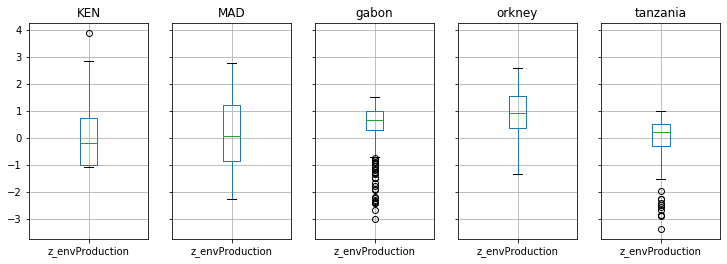

In [13]:
data[['z_envProduction', 'country']].groupby('country').boxplot(figsize=(12,4), layout=(1,5))
plt.show()

## Correlation heat-map for explanatory variables

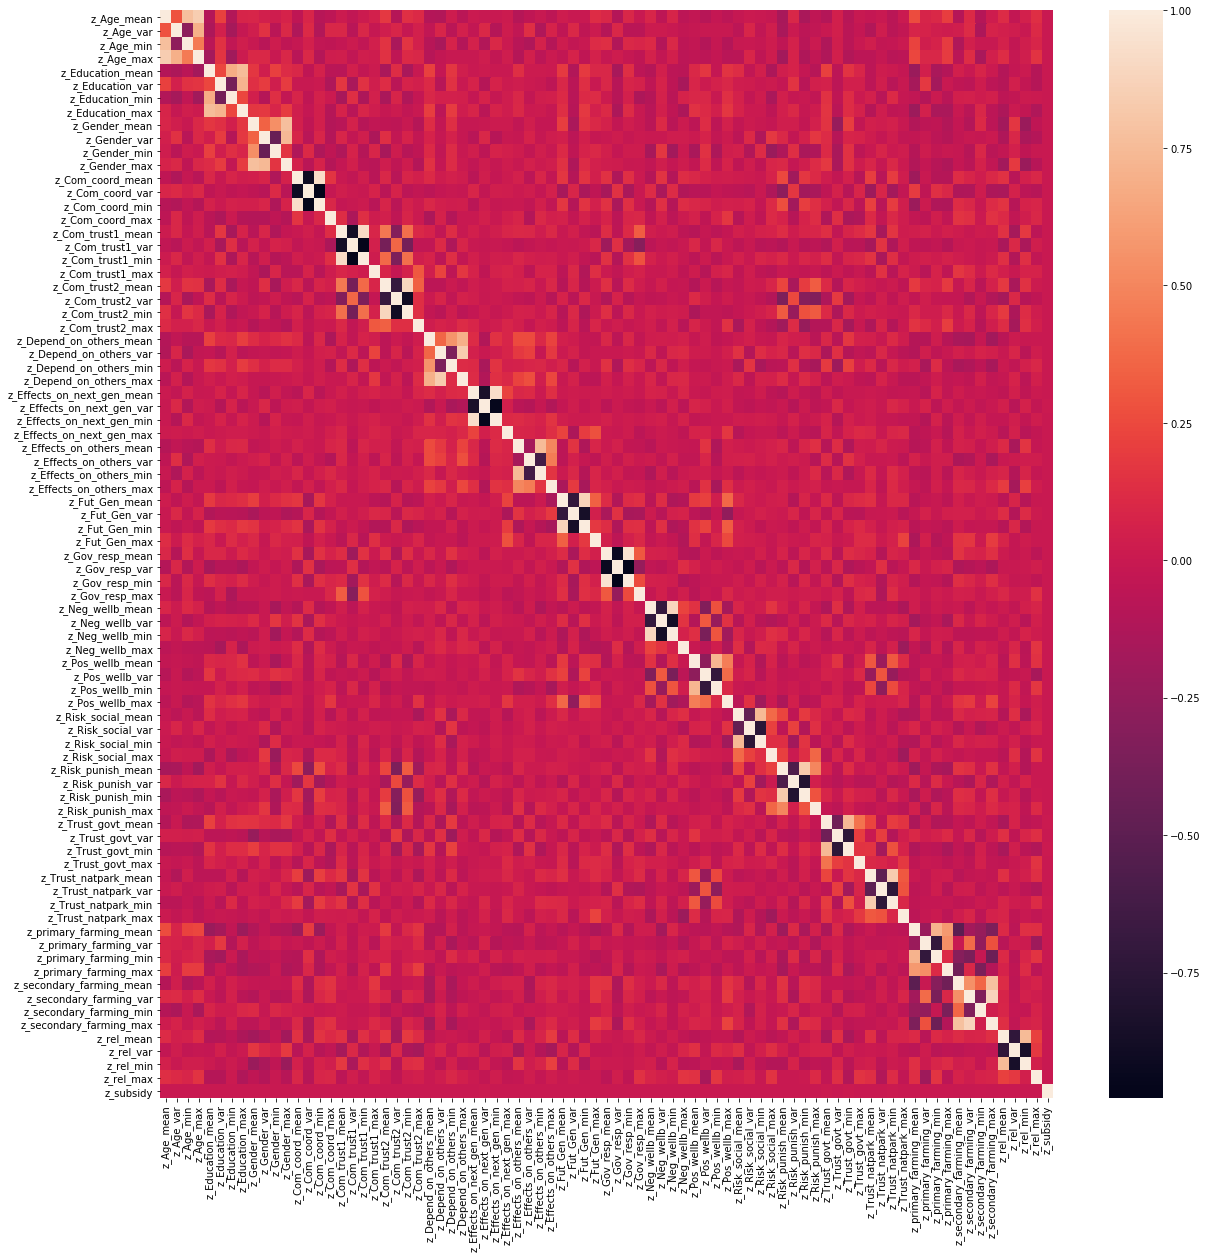

In [14]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data[explanatory_var].corr(), ax=ax)

#### Correlation between explanatory variables and response variable

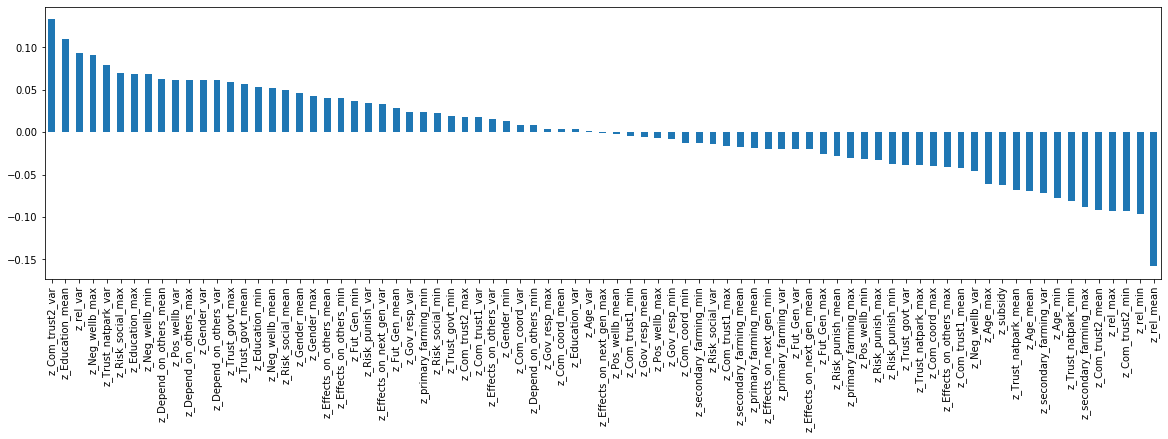

In [15]:
data[explanatory_var+[response_var]].corr()[response_var].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(20,5))

In [16]:
data[explanatory_var].corr().unstack().sort_values(ascending=False)[len(explanatory_var):]

z_Gov_resp_min             z_Gov_resp_mean               0.949482
z_Gov_resp_mean            z_Gov_resp_min                0.949482
z_Com_coord_mean           z_Com_coord_min               0.926597
z_Com_coord_min            z_Com_coord_mean              0.926597
z_Effects_on_next_gen_min  z_Effects_on_next_gen_mean    0.924409
                                                           ...   
z_Com_trust1_var           z_Com_trust1_min             -0.962878
z_Com_coord_var            z_Com_coord_min              -0.967195
z_Com_coord_min            z_Com_coord_var              -0.967195
z_Gov_resp_min             z_Gov_resp_var               -0.977519
z_Gov_resp_var             z_Gov_resp_min               -0.977519
Length: 6480, dtype: float64

## OLS regression analysis

In [17]:
# drop duplicate rows
print(len(data))
data.drop_duplicates(inplace=True)
print(len(data))

978
978


In [18]:
# write formula
formula = response_var + ' ~ '
for var in explanatory_var:
    formula += var + ' + '
formula = formula[:-3]

In [19]:
# define and fit model
model = smformula.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     z_varEnvProduction   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     2.101
Date:                Tue, 09 Mar 2021   Prob (F-statistic):           2.07e-07
Time:                        17:19:22   Log-Likelihood:                -1299.9
No. Observations:                 978   AIC:                             2764.
Df Residuals:                     896   BIC:                             3164.
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

#### ANOVA table (F-statistic and p-value)

In [20]:
table = sm.stats.anova_lm(results, typ=2) # Type 2 ANOVA DataFrame
print(table)

                      sum_sq     df         F    PR(>F)
z_Age_mean          0.142770    1.0  0.156523  0.692473
z_Age_var           0.245758    1.0  0.269432  0.603841
z_Age_min           0.001389    1.0  0.001522  0.968886
z_Age_max           0.350470    1.0  0.384230  0.535506
z_Education_mean    1.449505    1.0  1.589132  0.207778
...                      ...    ...       ...       ...
z_rel_var           1.196054    1.0  1.311266  0.252471
z_rel_min           0.857871    1.0  0.940507  0.332409
z_rel_max           7.557848    1.0  8.285874  0.004090
z_subsidy           3.660853    1.0  4.013493  0.045438
Residual          817.274264  896.0       NaN       NaN

[82 rows x 4 columns]


## Visualizing coefficients and beta coefficients

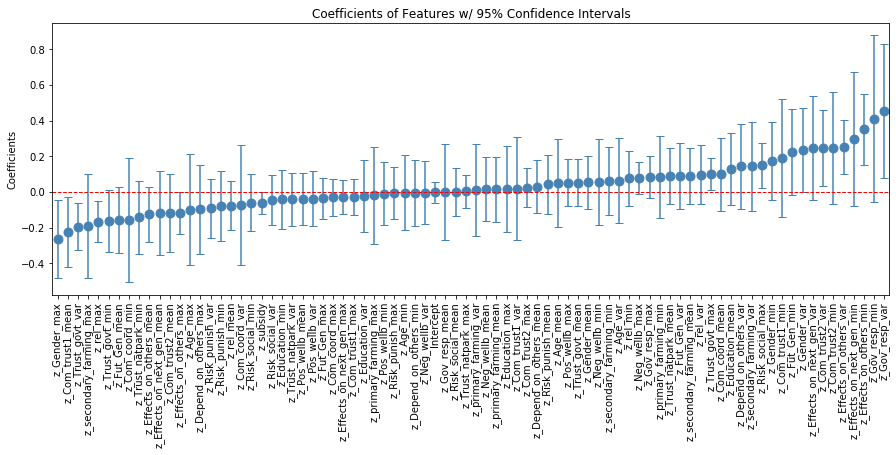

In [21]:
# Create dataframe of results summary 
coef_df = pd.DataFrame(results.summary().tables[1].data)
# Add column names
coef_df.columns = coef_df.iloc[0]
# Drop the extra row with column labels
coef_df=coef_df.drop(0)
# Set index to variable names 
coef_df = coef_df.set_index(coef_df.columns[0])
# Change datatype from object to float
coef_df = coef_df.astype(float)
# Get errors; (coef - lower bound of conf interval)
errors = coef_df['coef'] - coef_df['[0.025']
# Append errors column to dataframe
coef_df['errors'] = errors
# Sort values by coef ascending
coef_df = coef_df.sort_values(by=['coef'])
# Plot Coefficients
# x-labels
variables = list(coef_df.index.values)
# Add variables column to dataframe
coef_df['variables'] = variables
# Set sns plot style back to 'poster'
# This will make bars wide on plot
# Define figure, axes, and plot
fig, ax = plt.subplots(figsize=(15,5))
# Error bars for 95% confidence interval
# Can increase capsize to add whiskers
coef_df.plot(x='variables', y='coef', kind='bar',
             ax=ax, color='none', 
             ecolor='steelblue',capsize=4,
             yerr='errors', legend=False)
# Set title & labels
plt.title('Coefficients of Features w/ 95% Confidence Intervals')
ax.set_ylabel('Coefficients')
ax.set_xlabel('')
# Coefficients
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='o', s=80, 
           y=coef_df['coef'], color='steelblue')

# Line to define zero on the y-axis
ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
plt.show()

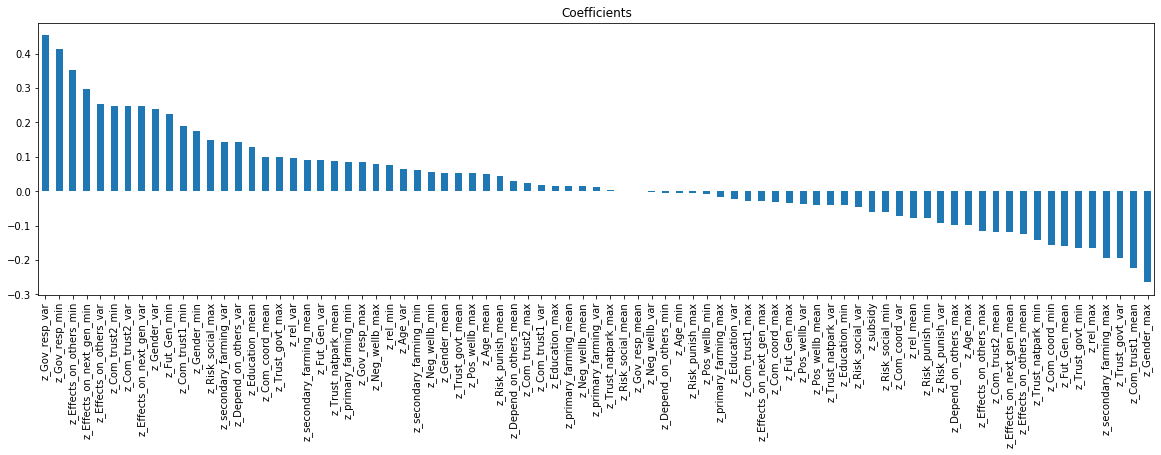

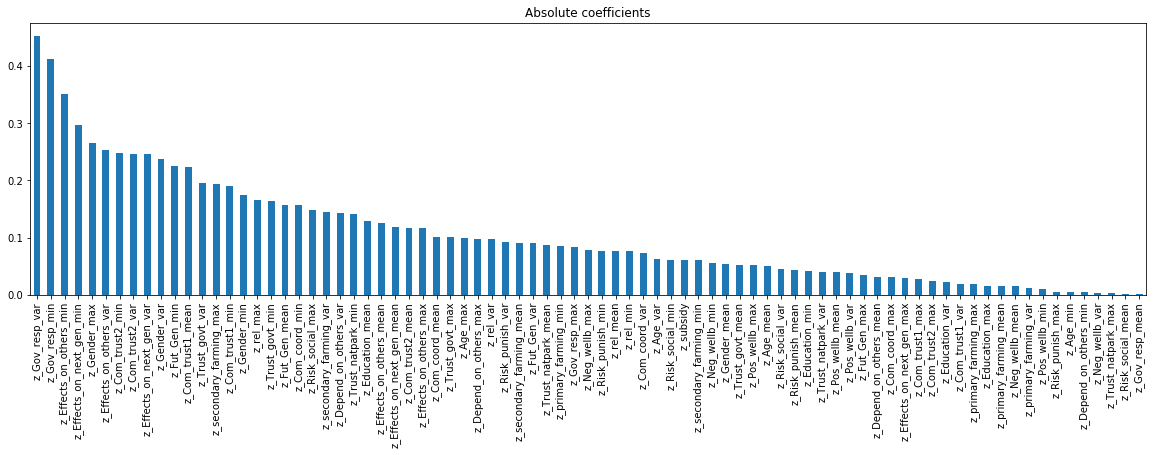

In [22]:
# plot coefficients
plt.figure(figsize=(20,5))
plt.title('Coefficients')
results.params.iloc[1:].sort_values(ascending=False).plot(kind='bar')
plt.show()

# plot absolute coefficients
plt.figure(figsize=(20,5))
plt.title('Absolute coefficients')
results.params.iloc[1:].abs().sort_values(ascending=False).plot(kind='bar')
plt.show()

## Heteroscedasticity Plot

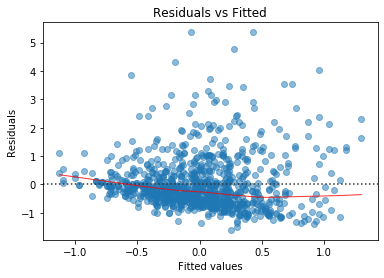

In [23]:
# model fitted values
model_fitted_y = results.fittedvalues
# model residuals
model_residuals = results.resid
# normalized residuals
model_norm_residuals = results.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = results.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = results.get_influence().cooks_distance[0]
plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, data[response_var], data=data[explanatory_var],
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

## Reduction in R2 if a variable is removed

In [24]:
orig_r2 = results.rsquared
for var in explanatory_var:
    temp_explanatory_var = explanatory_var.copy()
    temp_explanatory_var.remove(var)
    formula = response_var + ' ~ '
    for temp_var in temp_explanatory_var:
        formula += temp_var + ' + '
    formula = formula[:-3]
    temp_model = smformula.ols(formula, data=data).fit()
    print(var, temp_model.rsquared-results.rsquared)

z_Age_mean -0.00014680197376737425
z_Age_var -0.00025269888580892186
z_Age_min -1.4277341499058238e-06
z_Age_max -0.0003603674074765806
z_Education_mean -0.001490440049945807
z_Education_var -4.3754086908487366e-05
z_Education_min -0.00022945406832164394
z_Education_max -1.460006639775191e-05
z_Gender_mean -0.0004733754319972139
z_Gender_var -0.0036596319646964304
z_Gender_min -0.0022936368696043763
z_Gender_max -0.0052000344568226
z_Com_coord_mean -0.0008779195978668719
z_Com_coord_var -0.000164420290901246
z_Com_coord_min -0.0007307096373232458
z_Com_coord_max -0.000306372194458171
z_Com_trust1_mean -0.004671814602230651
z_Com_trust1_var -1.4958985450674867e-05
z_Com_trust1_min -0.0011889480175548695
z_Com_trust1_max -0.0002696096950731697
z_Com_trust2_mean -0.001032224591737907
z_Com_trust2_var -0.004744379889072503
z_Com_trust2_min -0.0022475217508926004
z_Com_trust2_max -0.00016483892748431206
z_Depend_on_others_mean -0.00015551304532157584
z_Depend_on_others_var -0.00129762181610

## Relative weights analysis

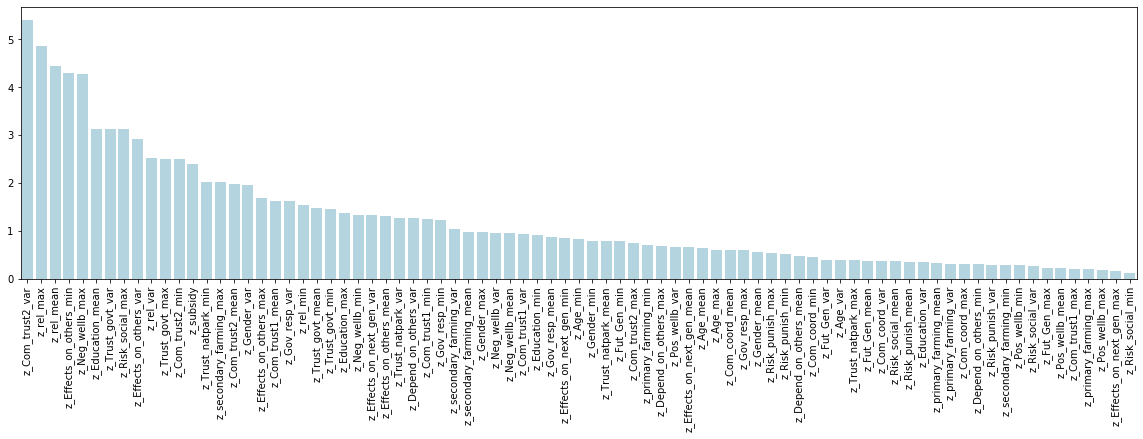

In [25]:
num_drivers = len(explanatory_var)
# Get a correlation between all of the dependent and independent variables.
corr_matrix = data[[response_var]+explanatory_var].apply(pd.to_numeric, errors = 'coerce').corr()
corr_Xs = corr_matrix.iloc[1:, 1:].copy()
corr_Xy = corr_matrix.iloc[1:, 0].copy()
# Create orthogonal predictors using eigenvectors and eigenvalues on the correlation matrix, creating a diagonal matrix
# of the square root of eigenvalues. This gets around the issue of multi-collinearity.
w_corr_Xs, v_corr_Xs = np.linalg.eig(corr_Xs)
diag_idx = np.diag_indices(len(corr_Xs))
diag = np.zeros((num_drivers, num_drivers), float)
diag[diag_idx] = w_corr_Xs
delta = np.sqrt(diag)
# Multiply the eigenvector matrix and its transposition. This allows us to treat X as the set of dependent variables, 
# regressing X onto matrix Z — itself the orthogonal counterpart of X having the least squared error. To get the partial 
# effect of each independent variable, we apply matrix multiplication to the inverse and correlation matricies.
coef_xz = v_corr_Xs @ delta @ v_corr_Xs.transpose()
coef_yz = np.linalg.inv(coef_xz) @ corr_Xy
# We then calculate the relative weight as the multiplication of the matrix in Step 2 and step 3. 
# The normalized version is then the percentage of r2 that these account for.
# Also, the sum of the squares of coef_yz above should add up to the total R2
r2 = sum(np.square(coef_yz))
raw_relative_weights = np.square(coef_xz) @ np.square(coef_yz)
normalized_relative_weights = (raw_relative_weights/r2)*100
idx = np.argsort(normalized_relative_weights)[::-1]
plt.figure(figsize=(20,5))
sns.barplot(x=corr_matrix.columns[1:][idx], y=np.sort(normalized_relative_weights)[::-1], color="lightblue")
plt.xticks(rotation=90)
plt.show()

## Scatter/regression plots for mean response_var grouped by explanatory variable

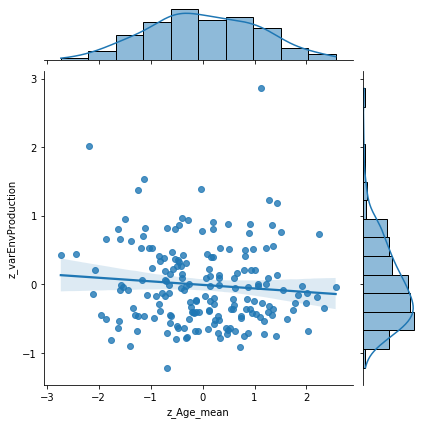

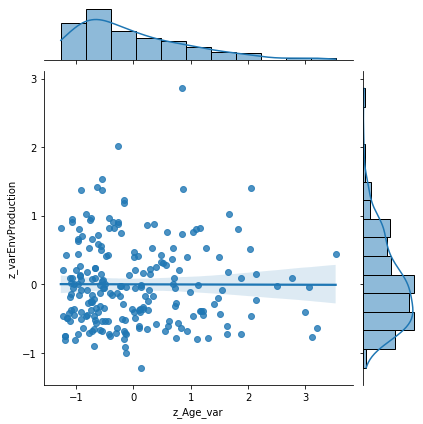

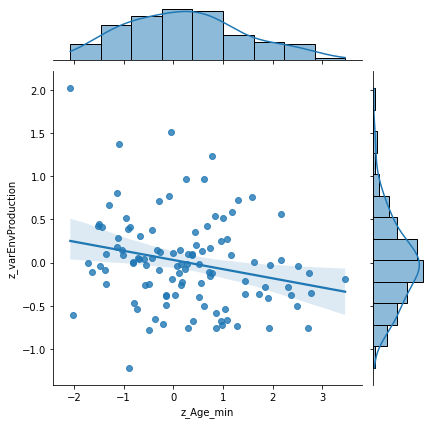

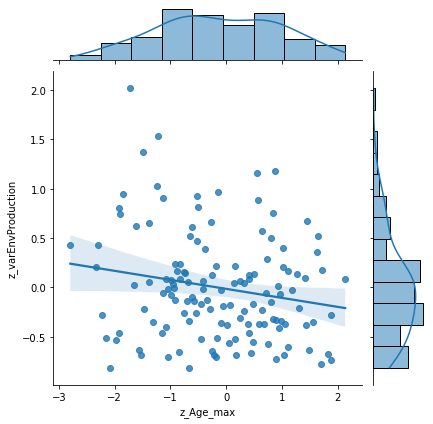

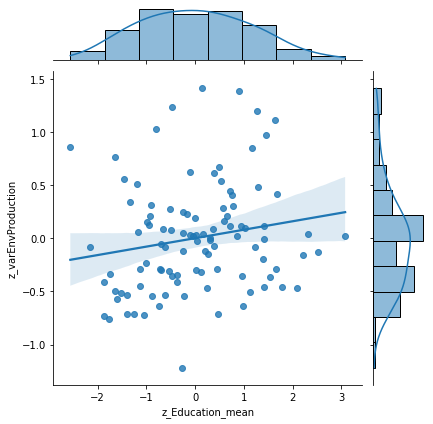

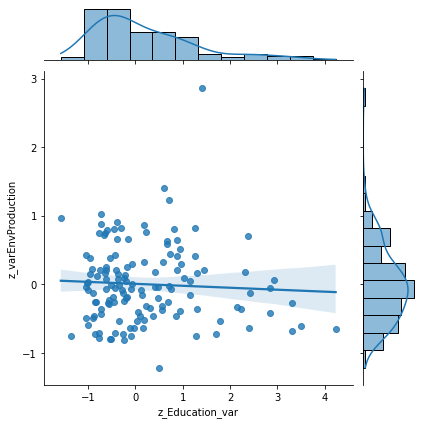

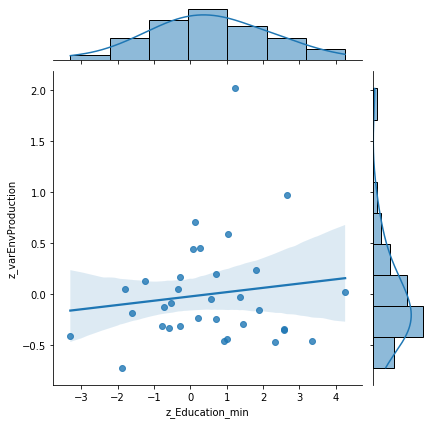

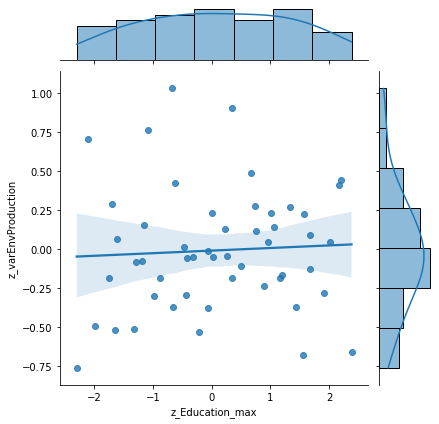

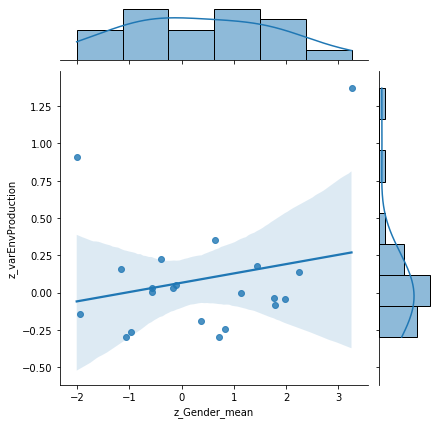

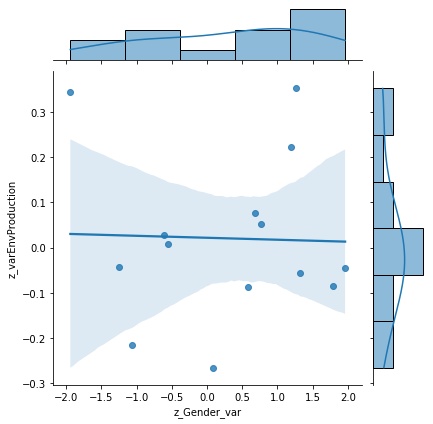

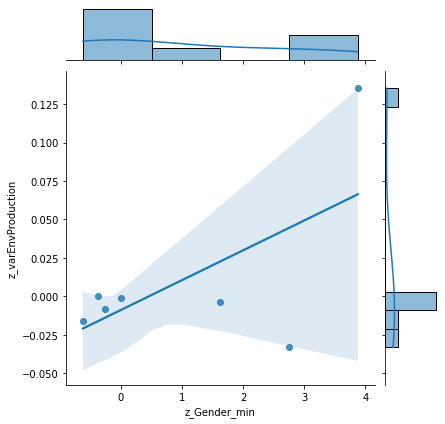

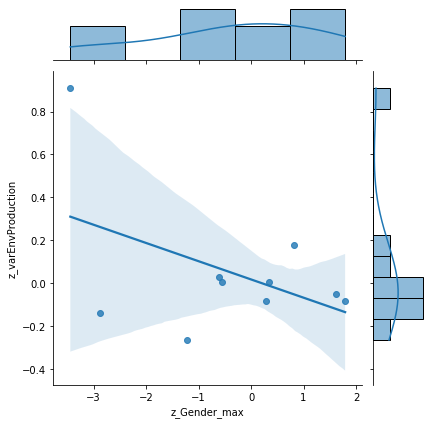

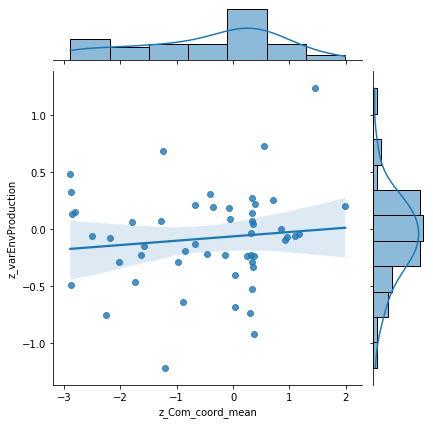

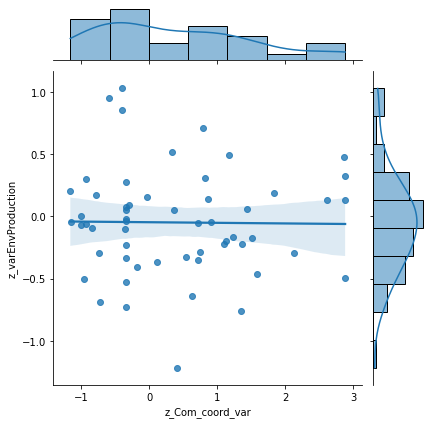

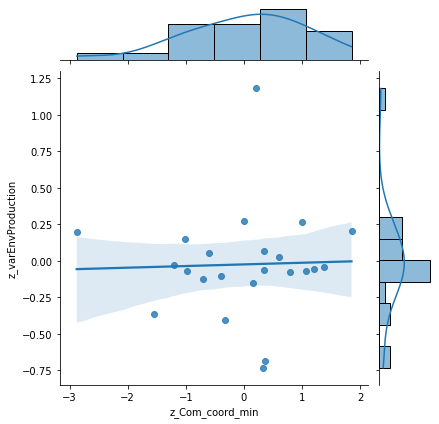

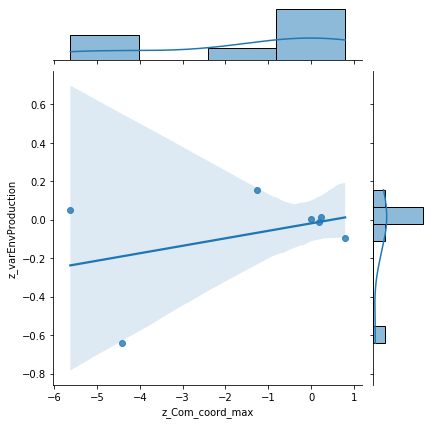

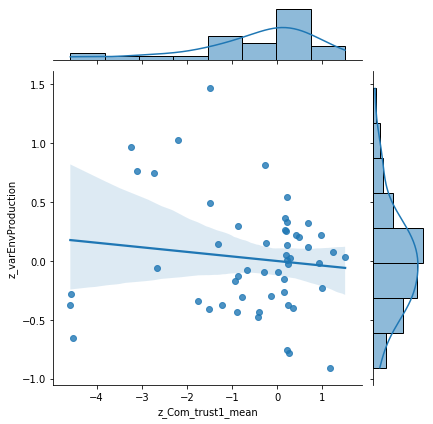

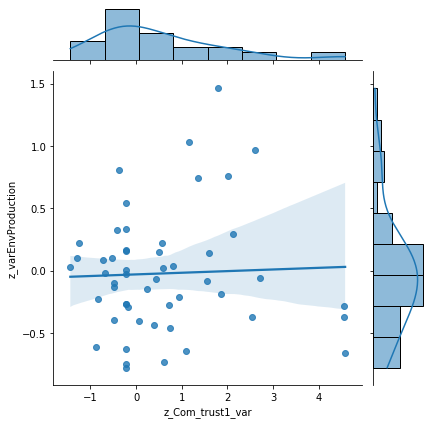

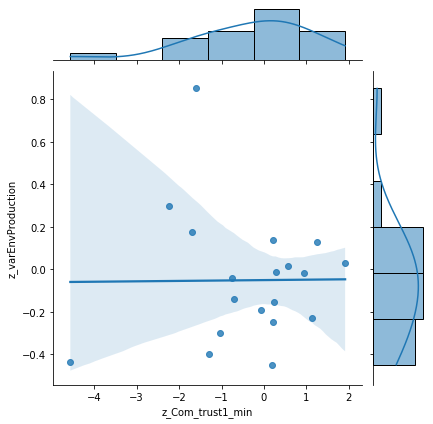

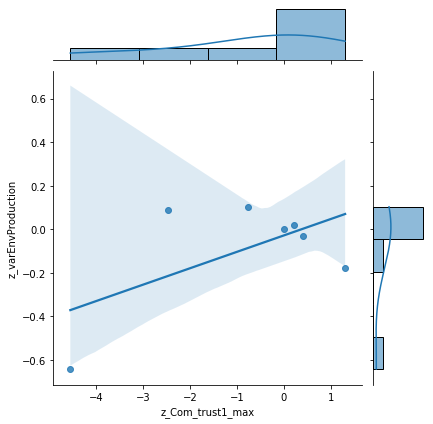

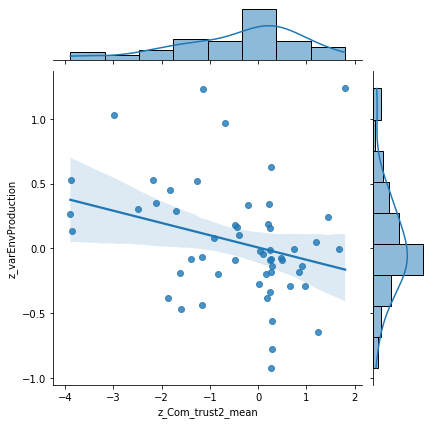

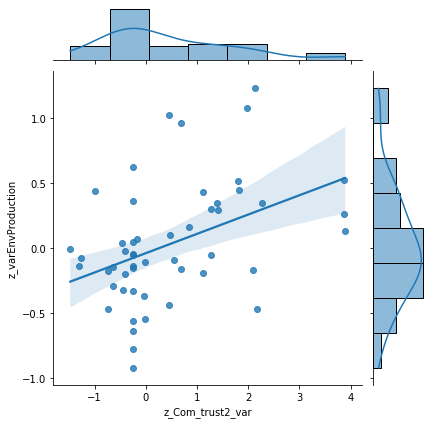

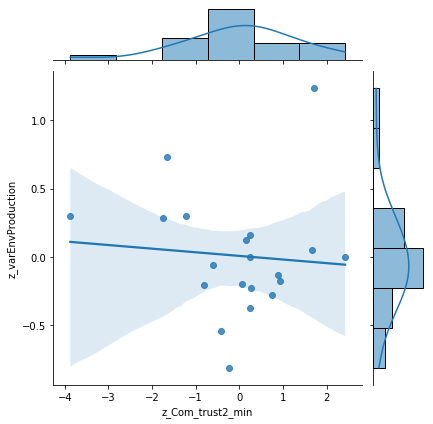

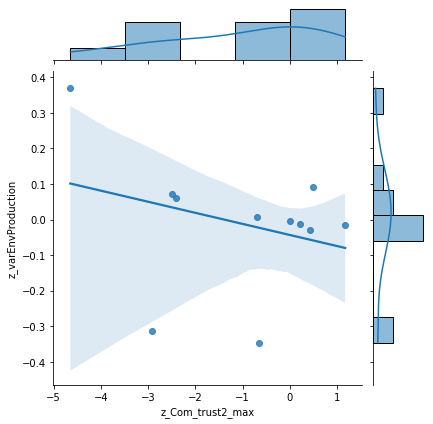

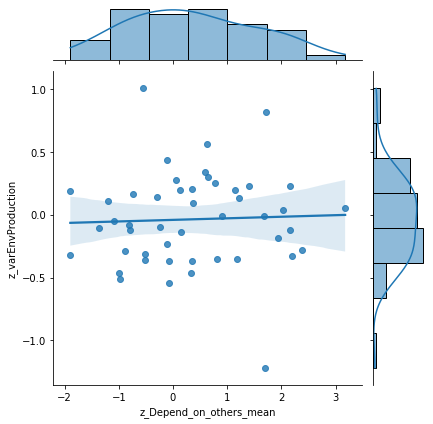

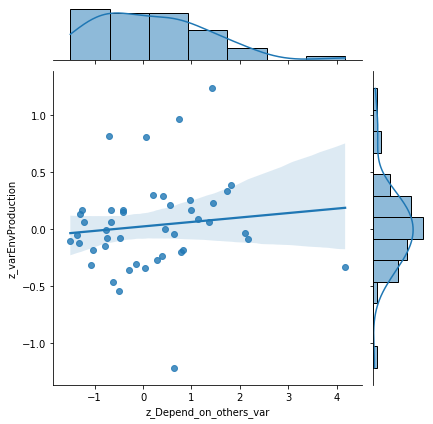

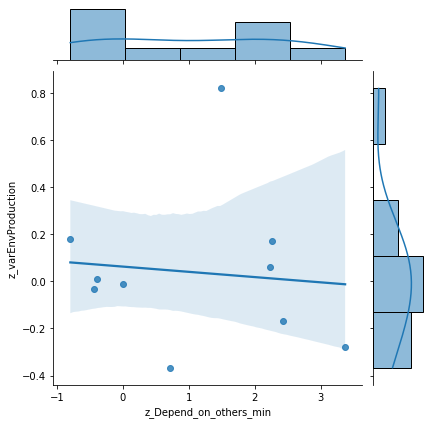

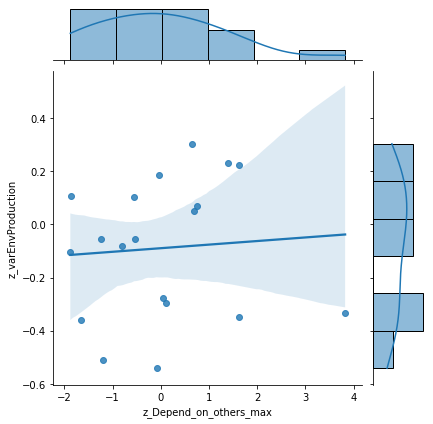

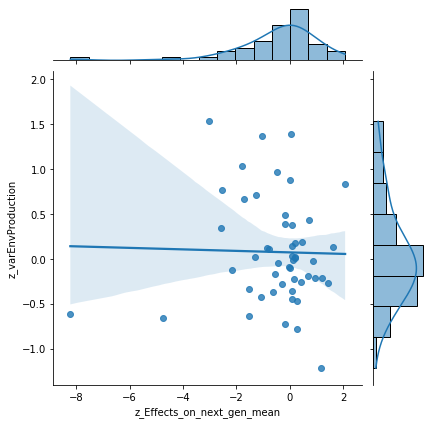

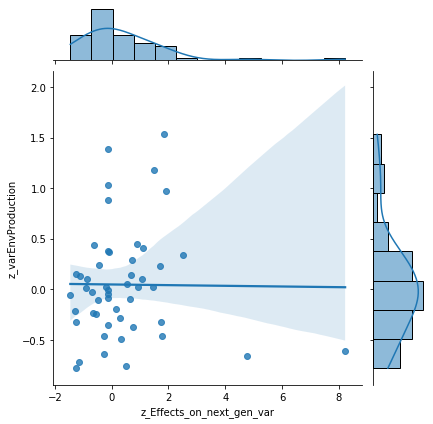

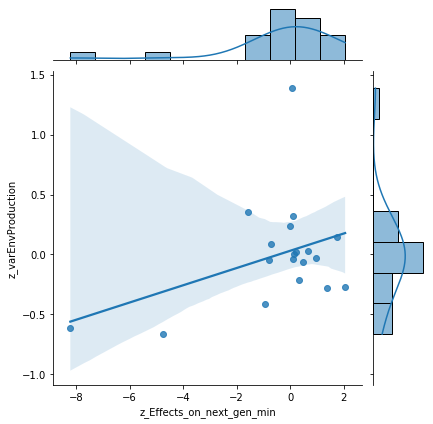

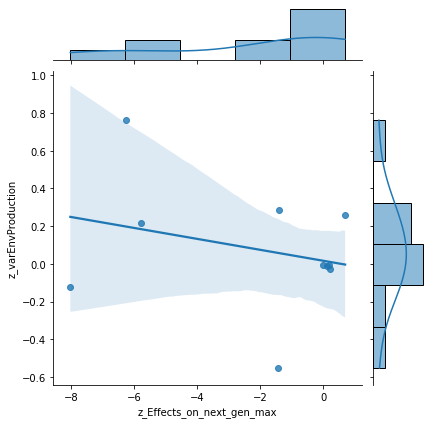

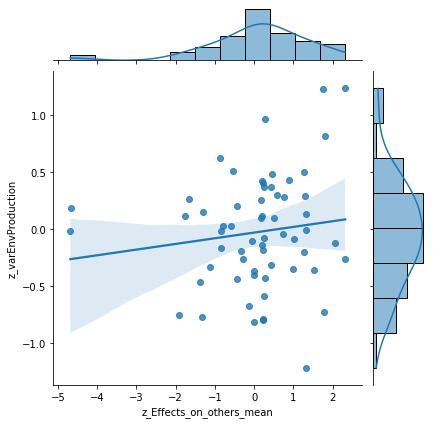

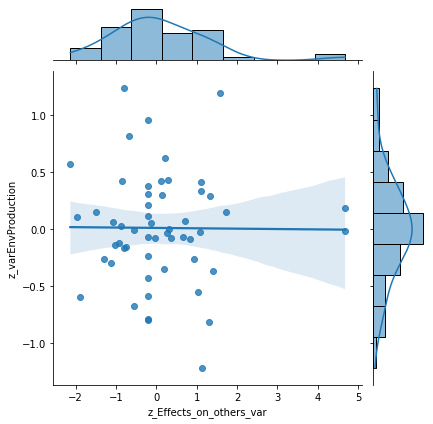

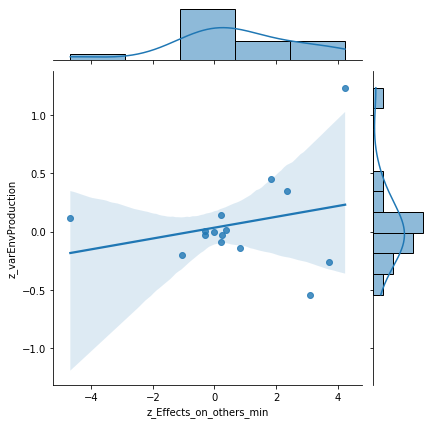

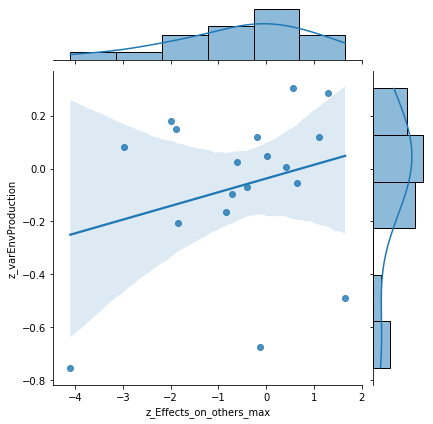

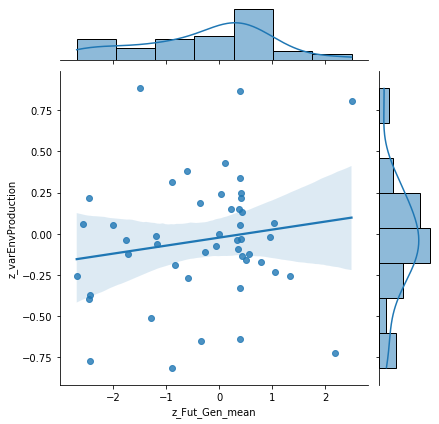

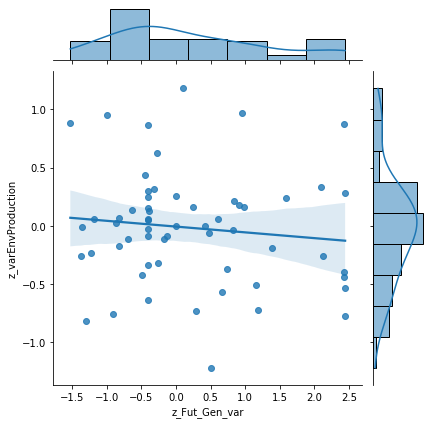

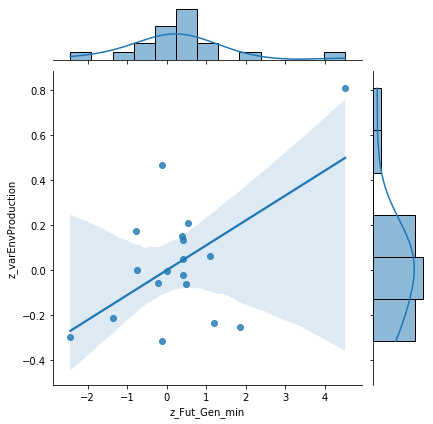

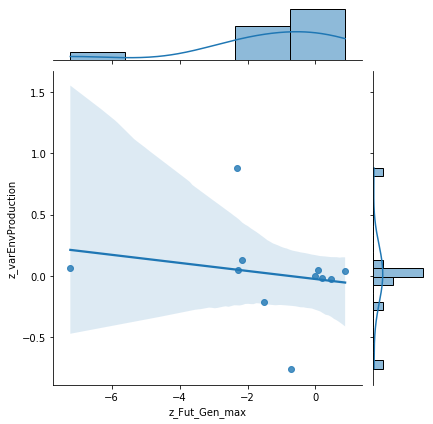

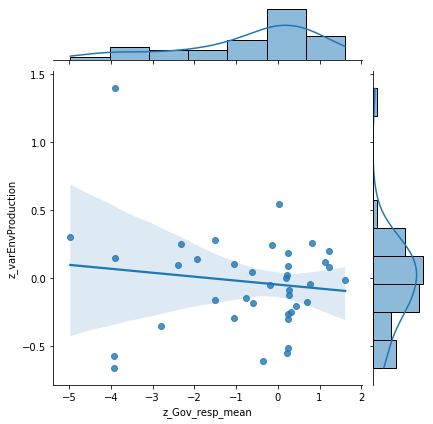

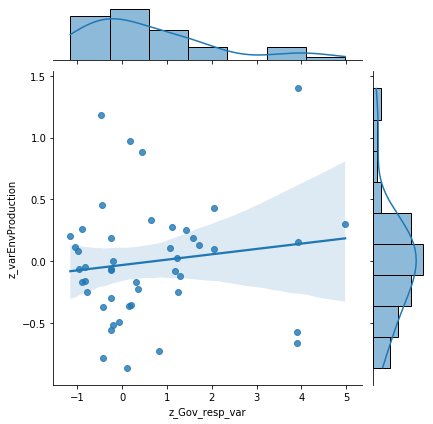

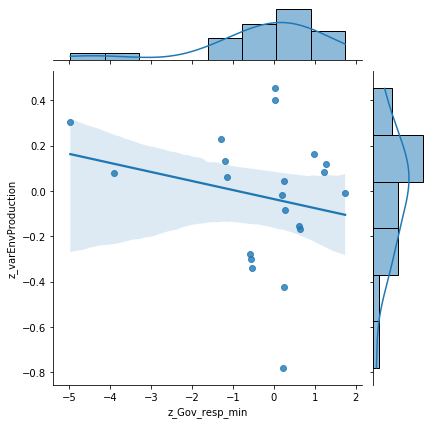

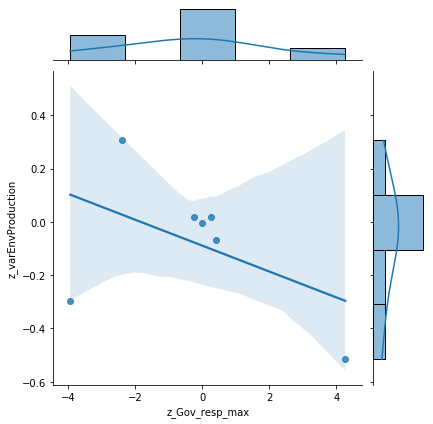

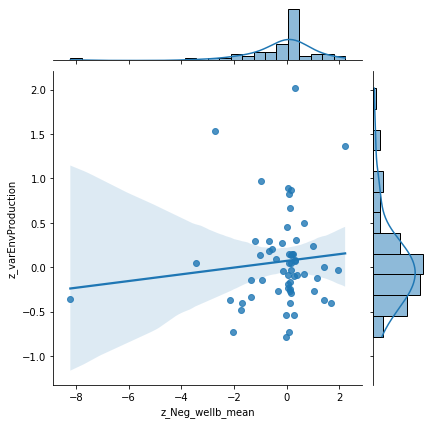

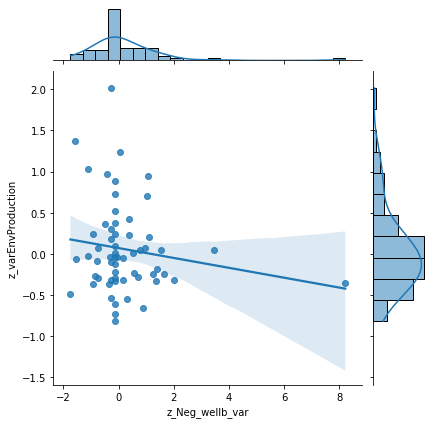

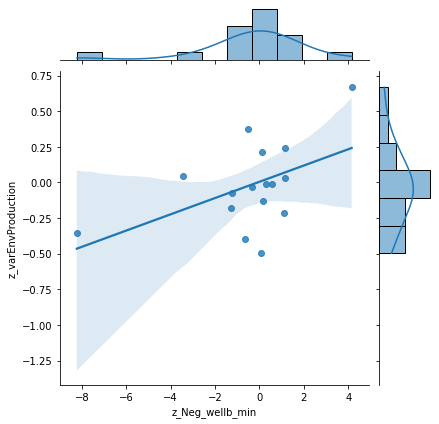

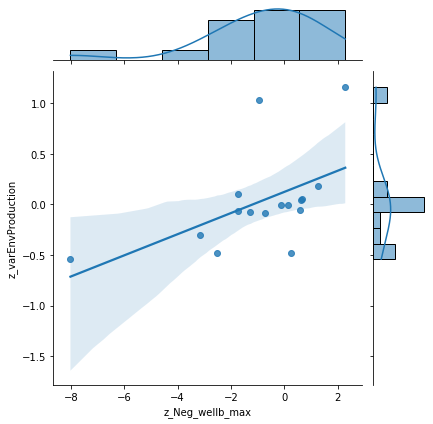

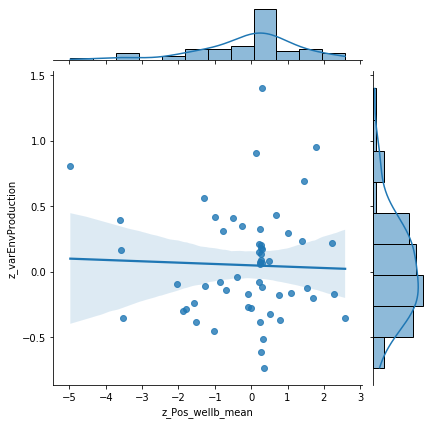

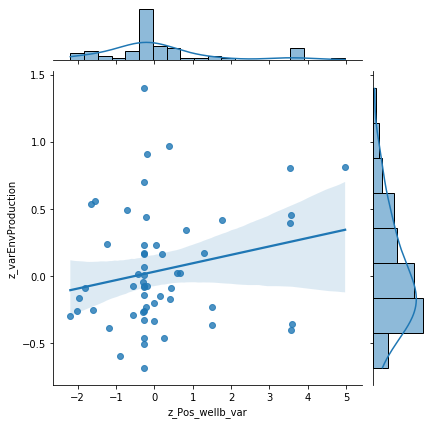

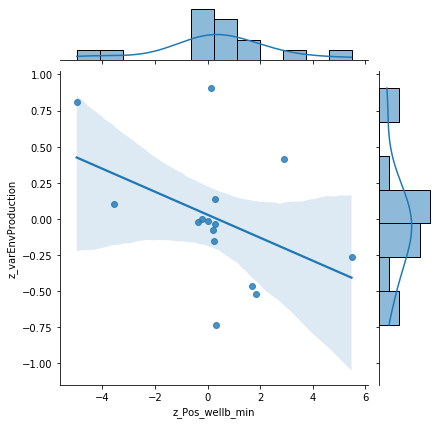

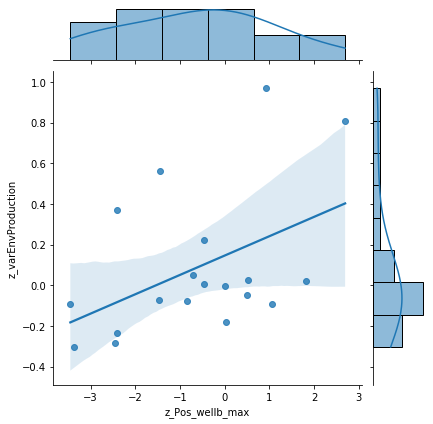

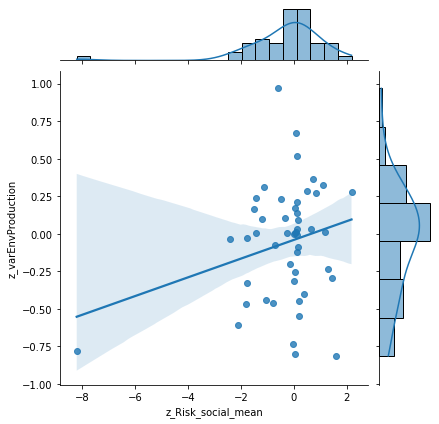

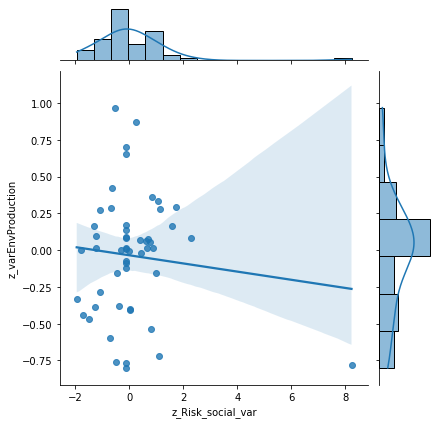

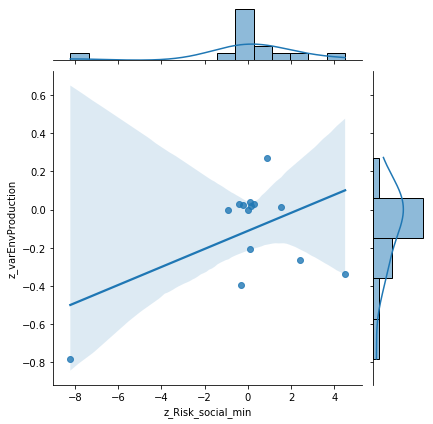

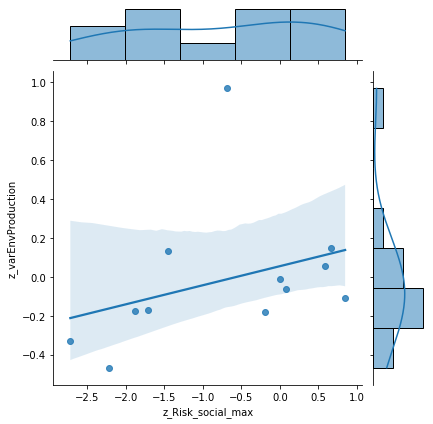

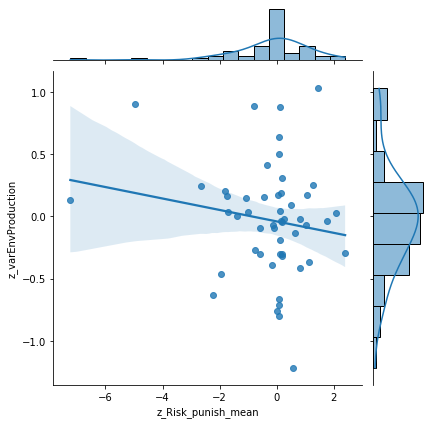

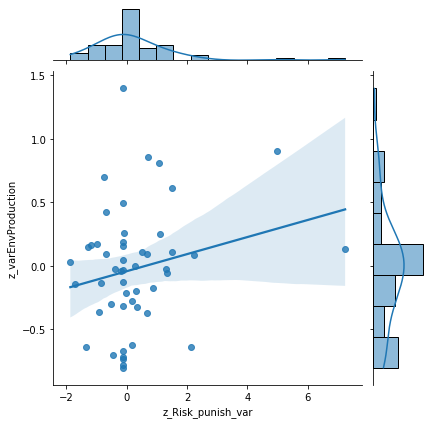

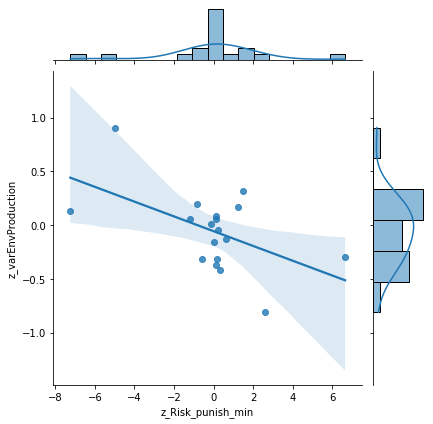

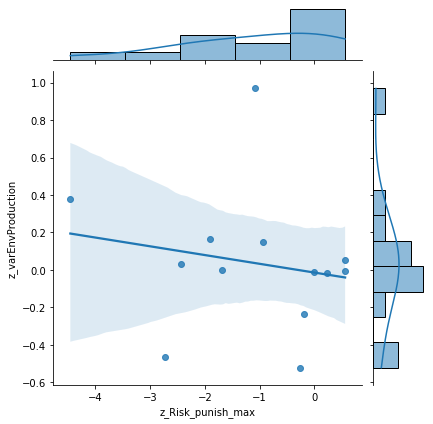

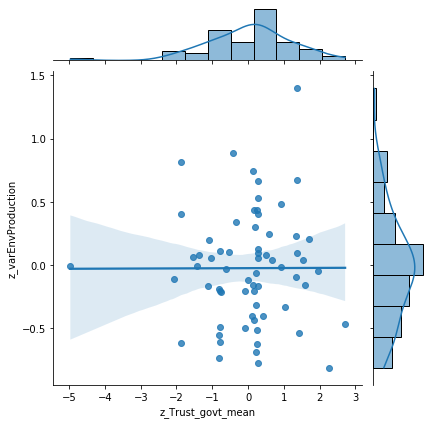

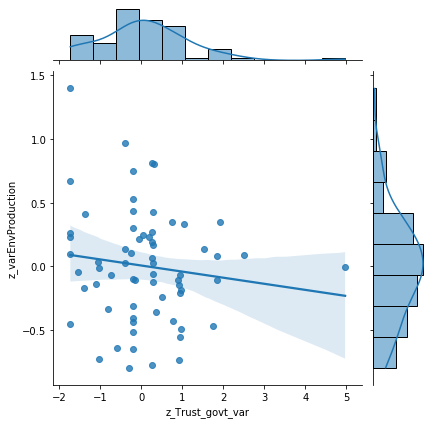

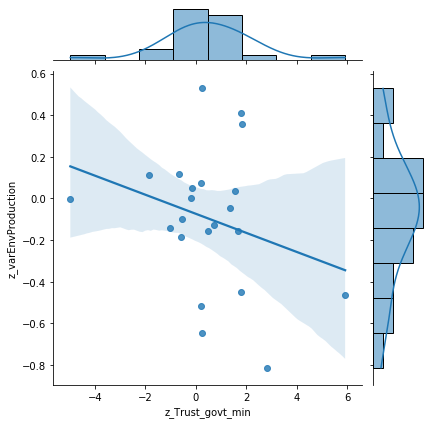

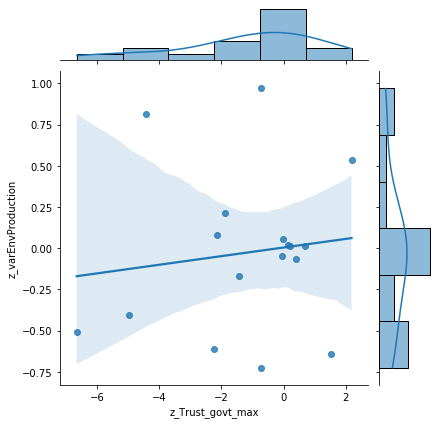

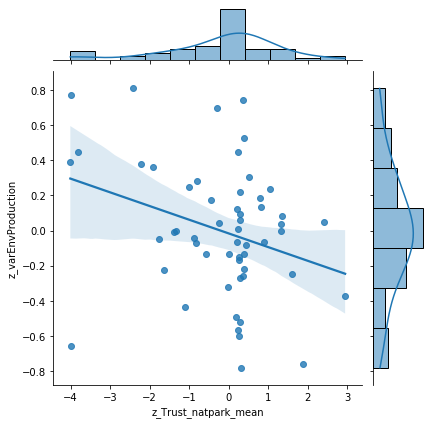

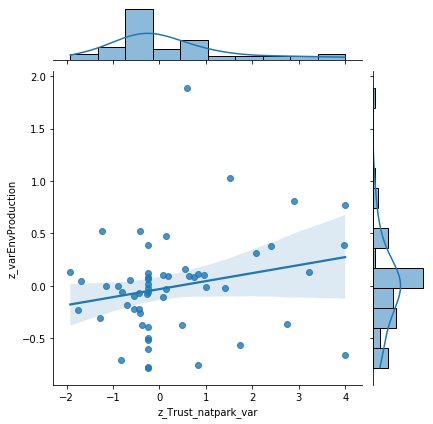

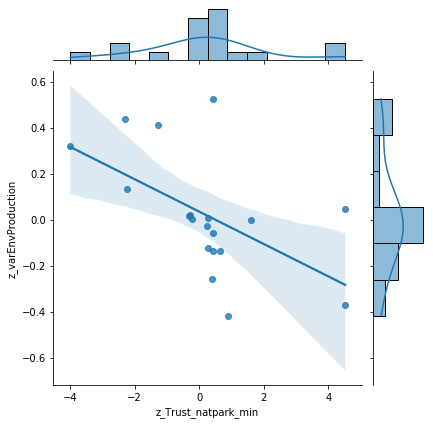

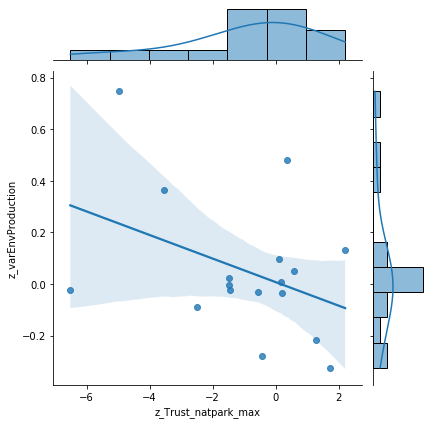

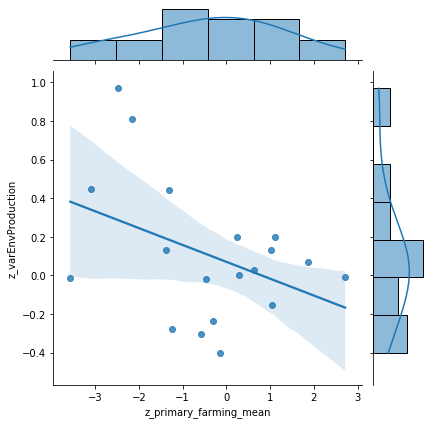

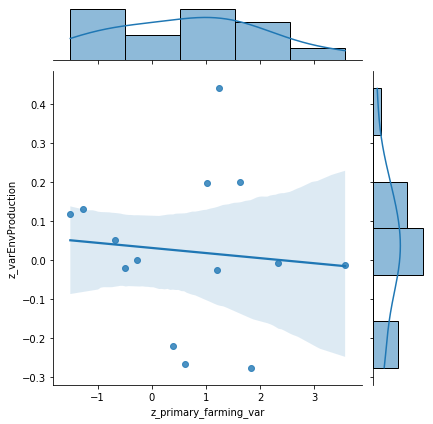

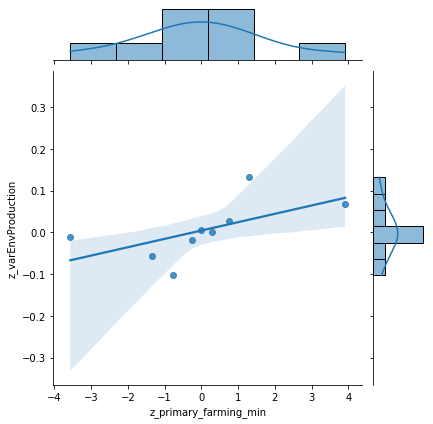

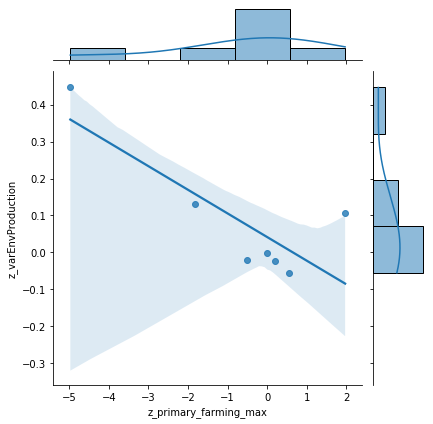

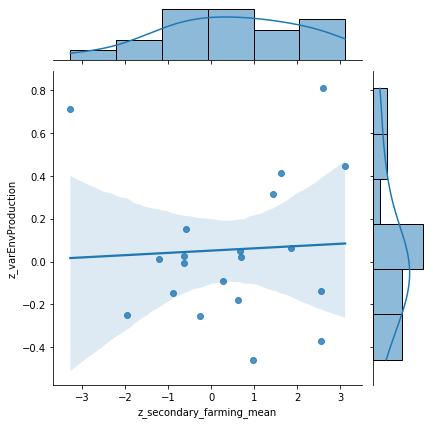

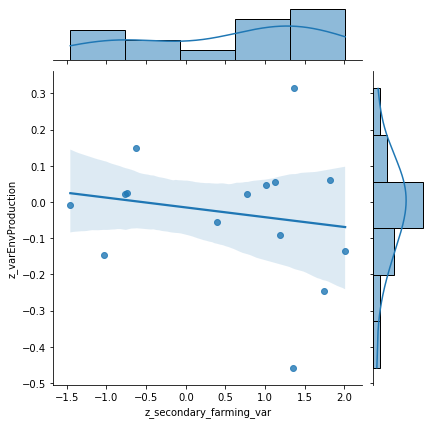

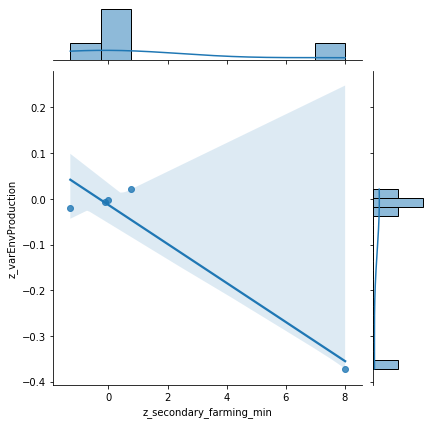

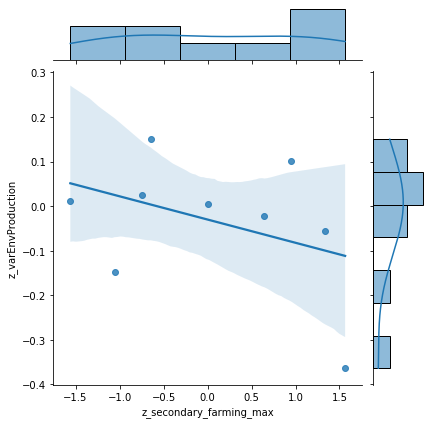

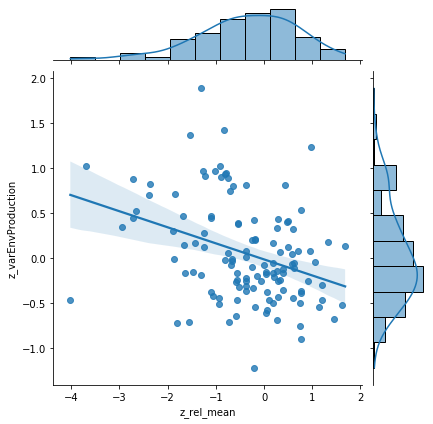

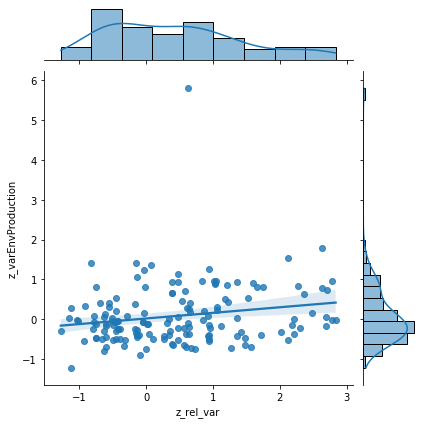

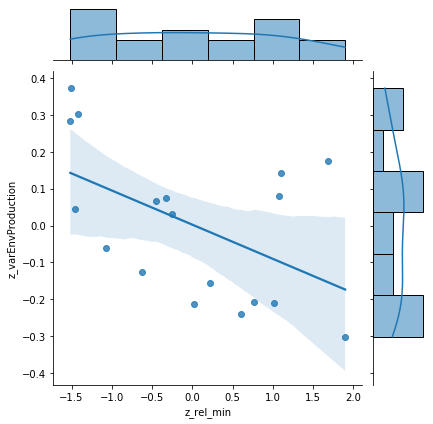

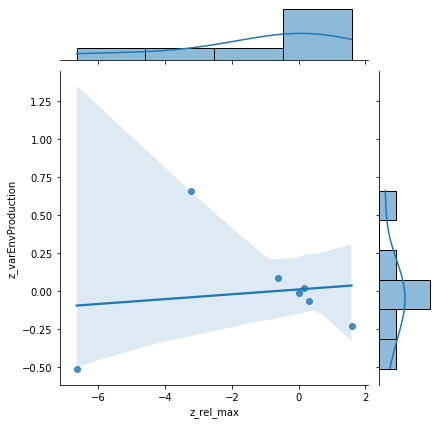

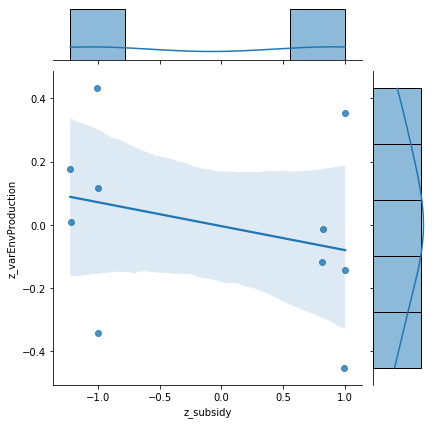

In [26]:
for var in explanatory_var:
    df = data[[var, response_var]].groupby(var).mean().reset_index()
    sns.jointplot(x=var, y=response_var, data=df, kind='reg')
    plt.show()

## Moving average and cubic regression plot for response_var against explanatory variable

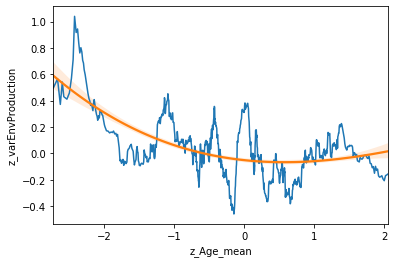

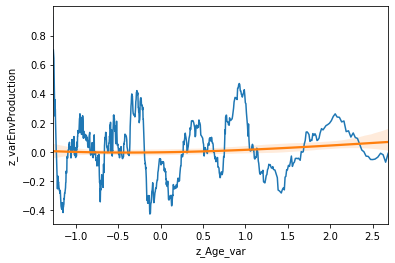

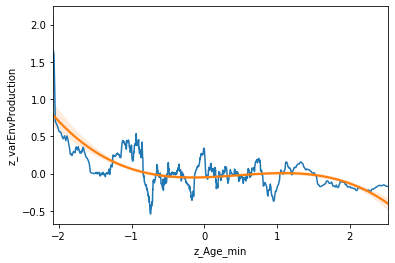

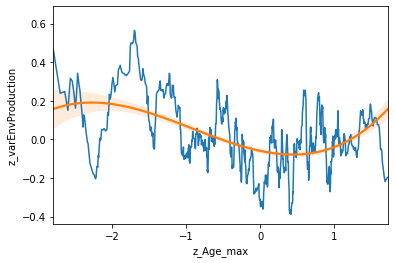

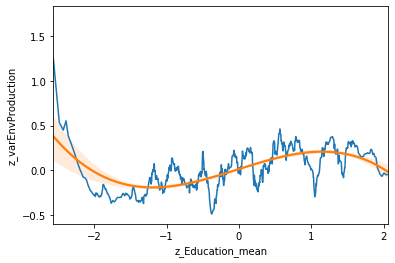

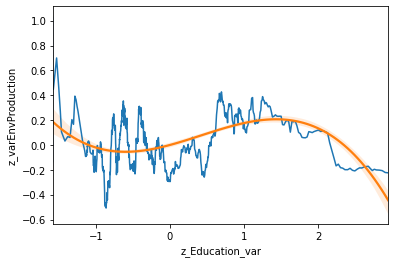

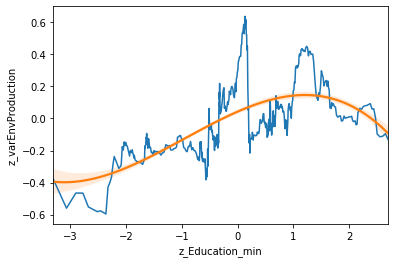

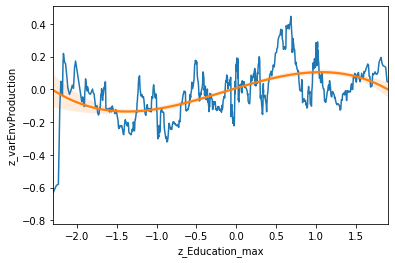

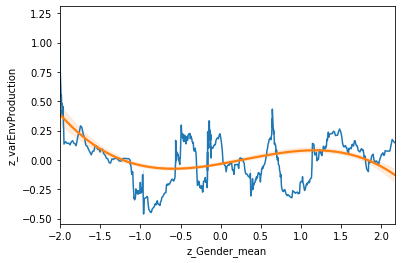

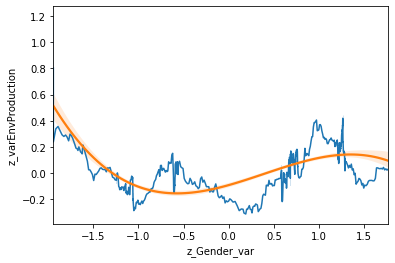

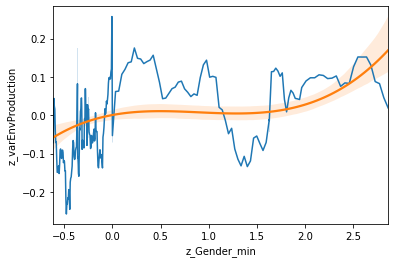

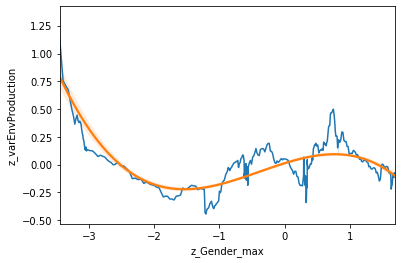

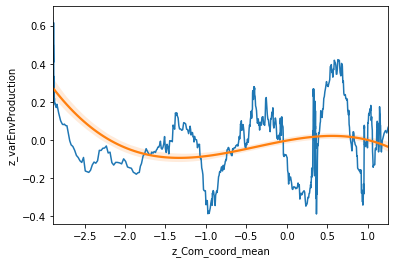

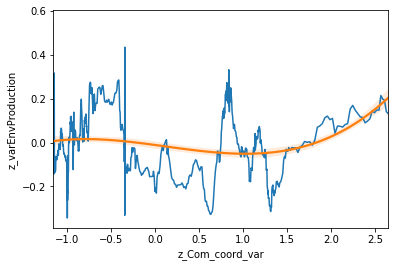

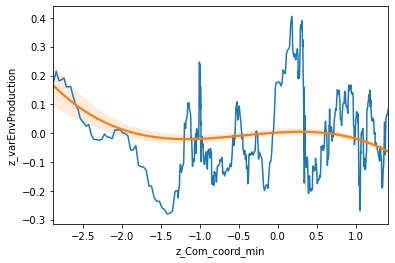

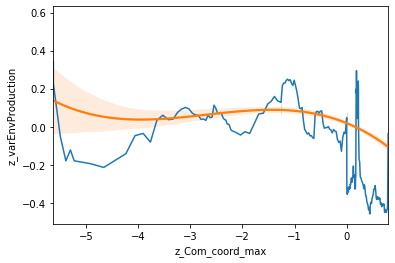

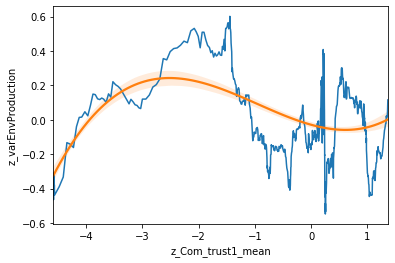

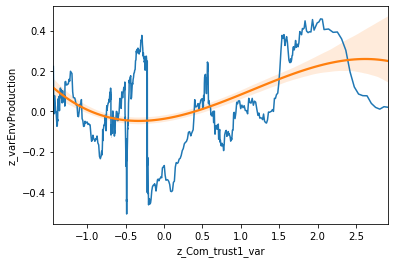

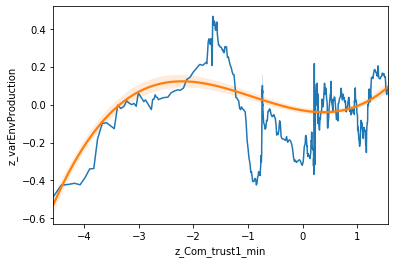

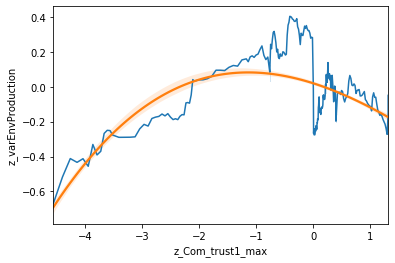

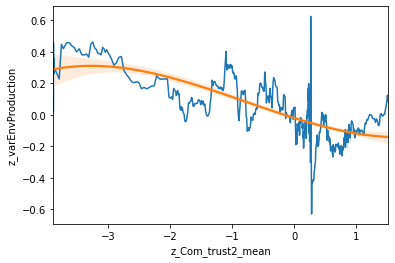

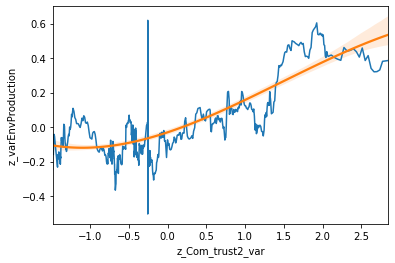

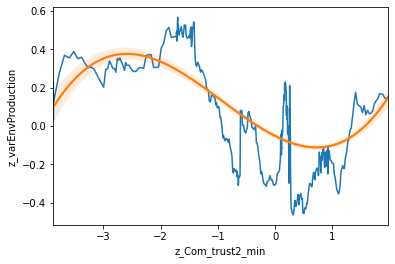

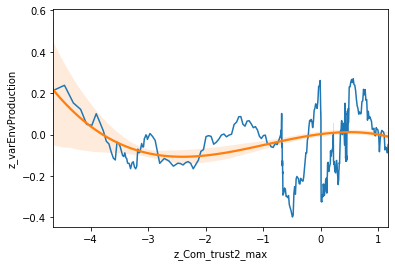

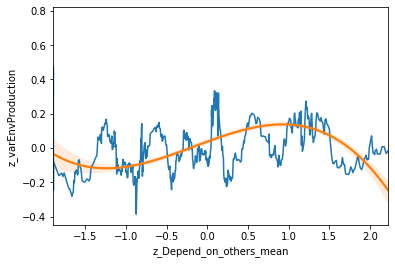

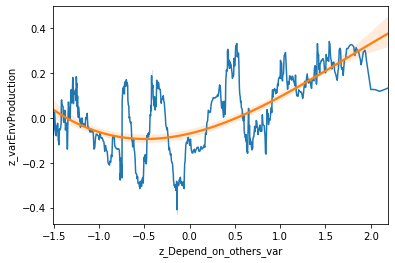

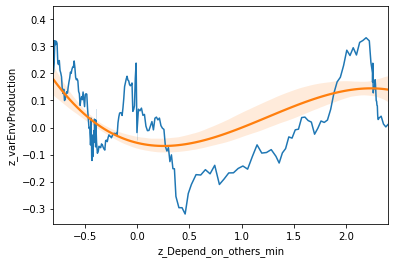

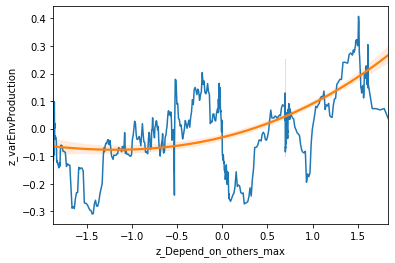

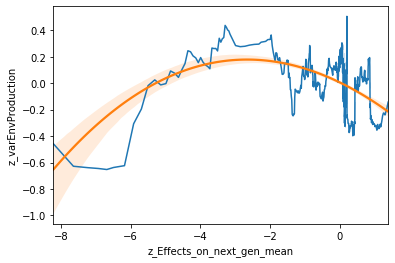

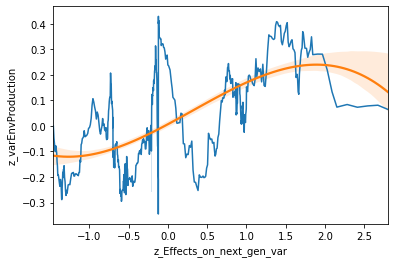

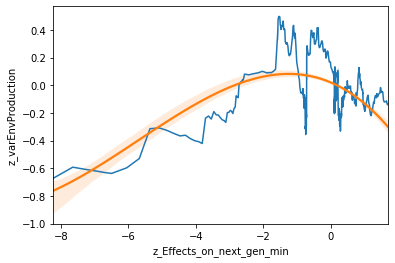

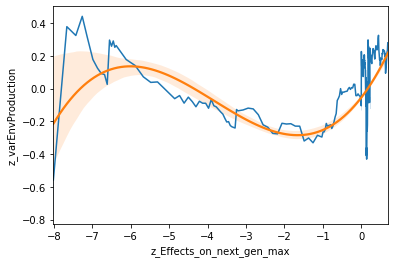

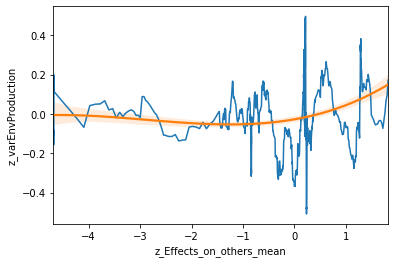

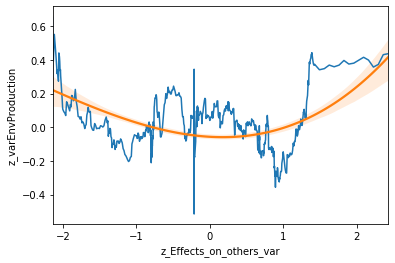

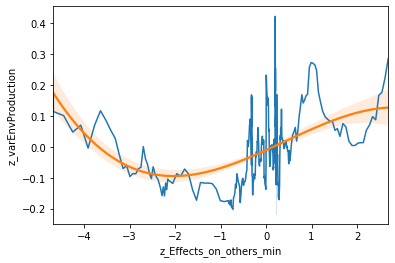

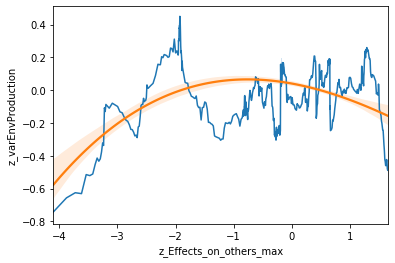

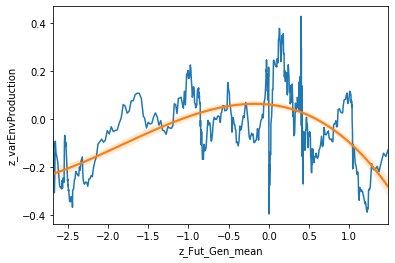

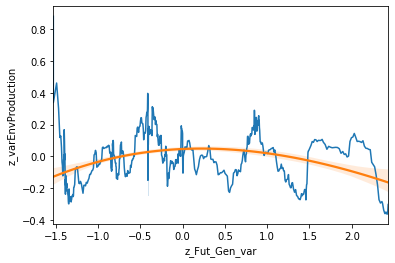

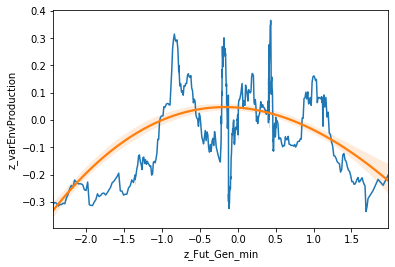

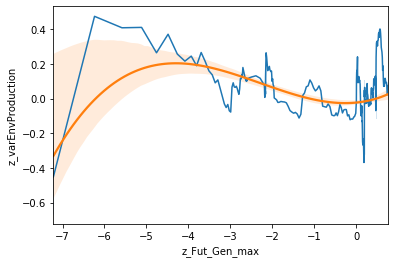

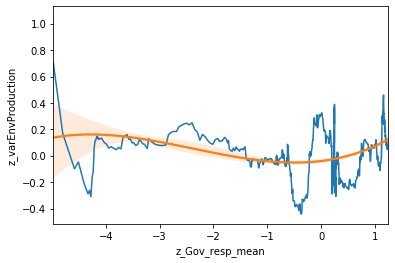

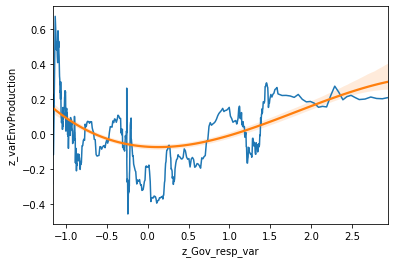

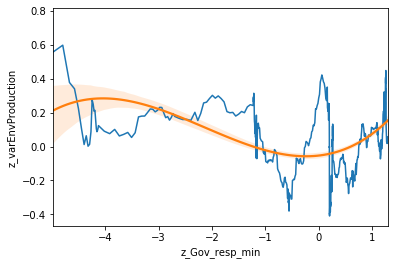

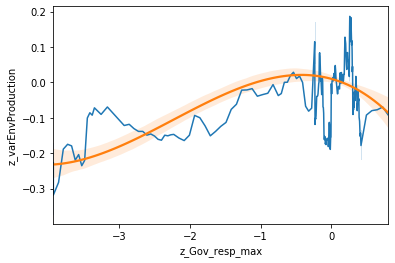

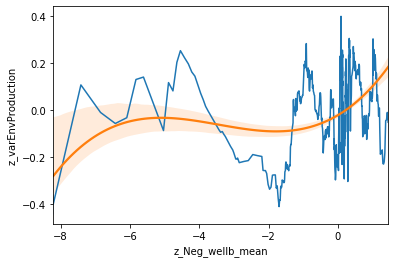

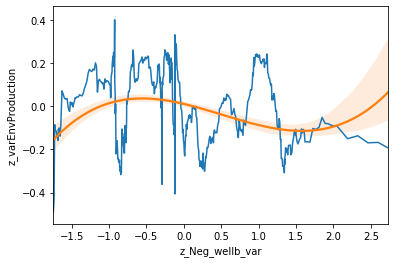

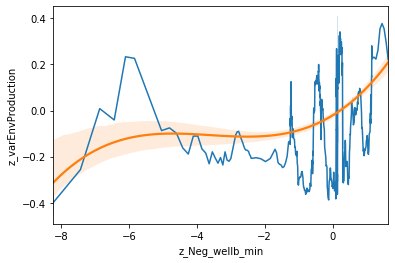

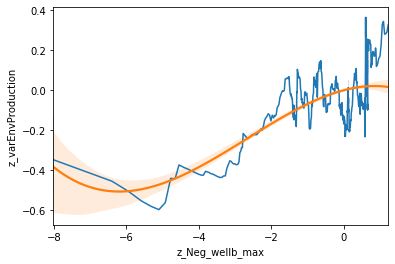

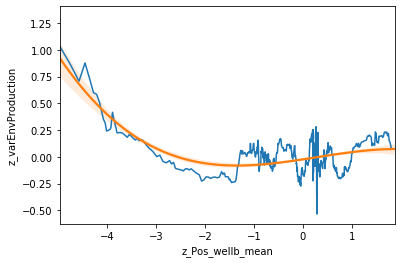

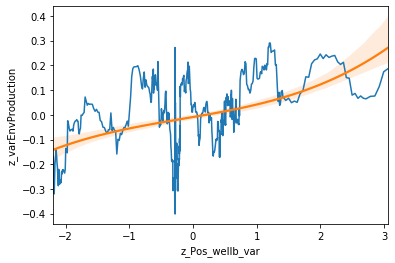

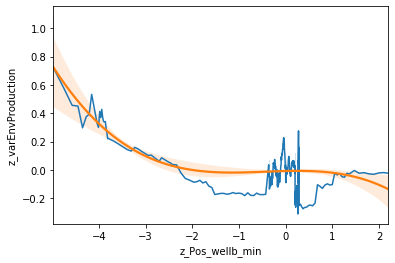

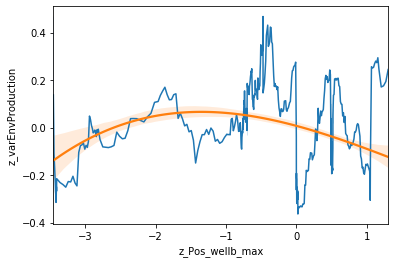

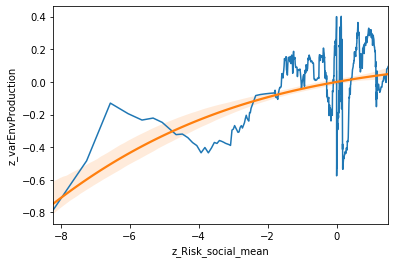

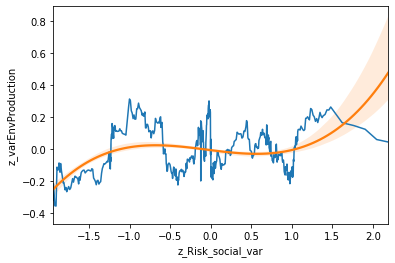

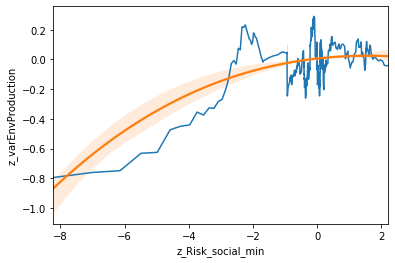

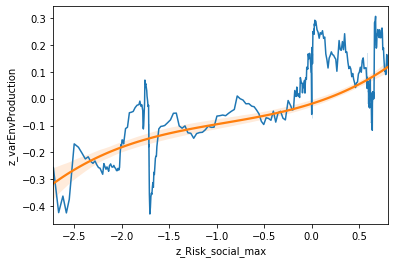

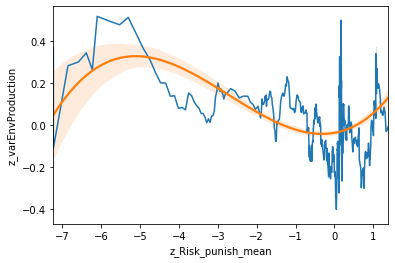

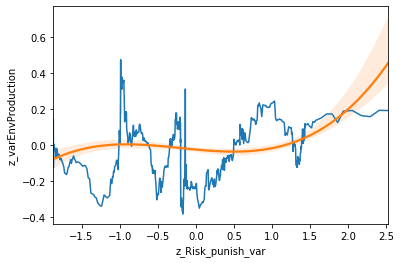

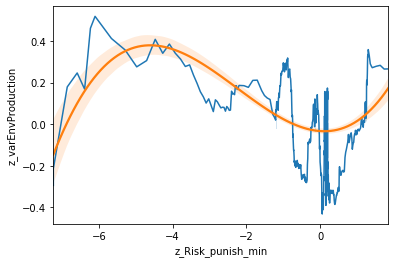

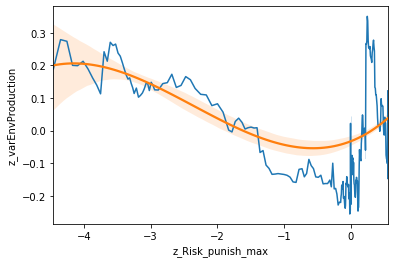

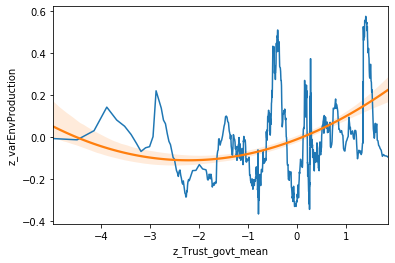

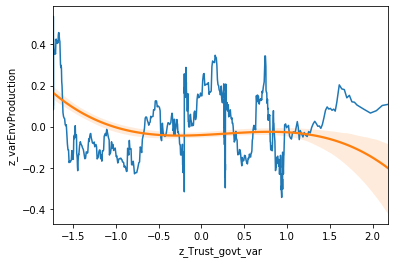

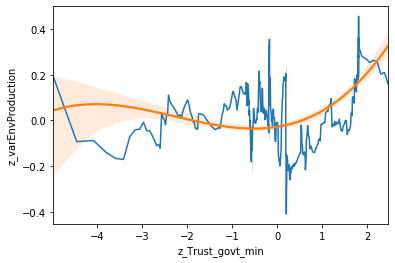

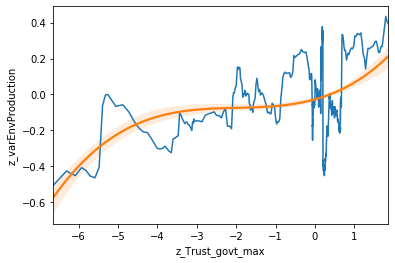

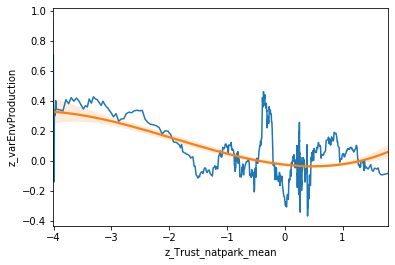

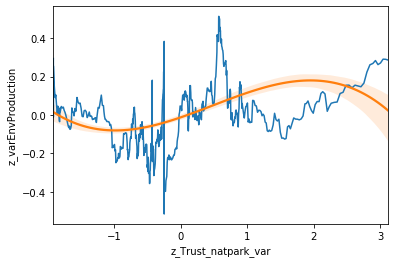

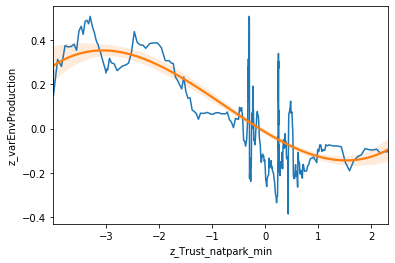

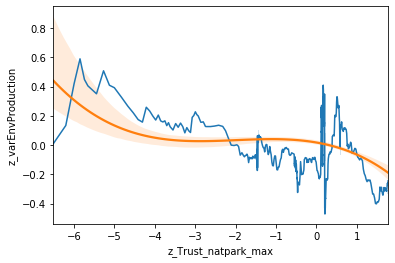

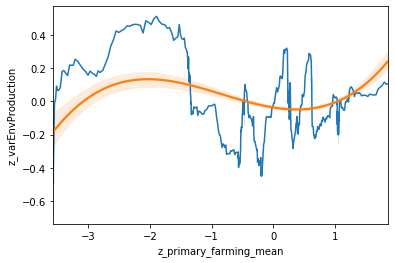

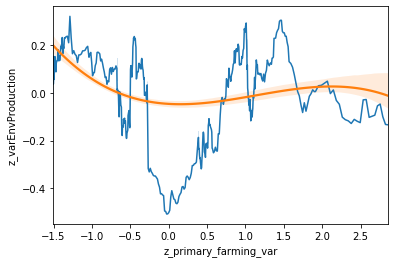

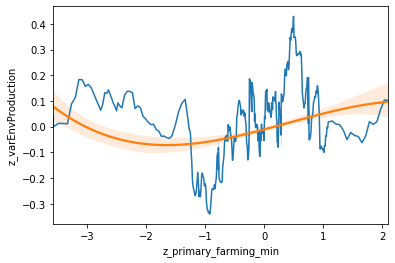

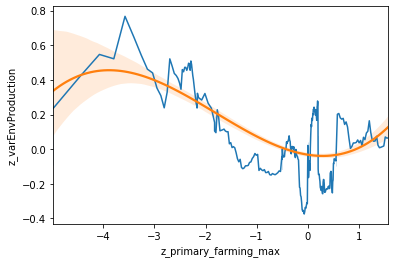

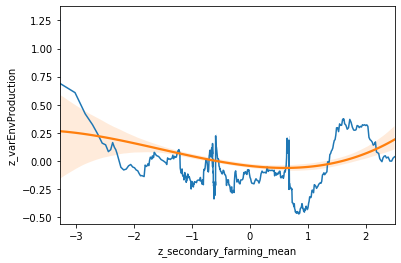

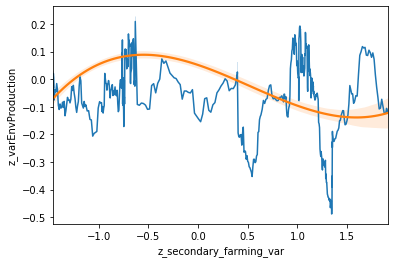

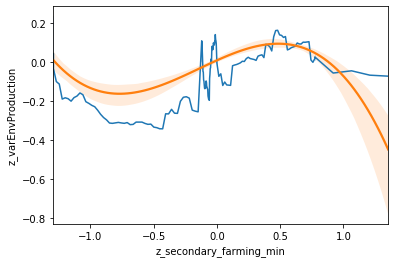

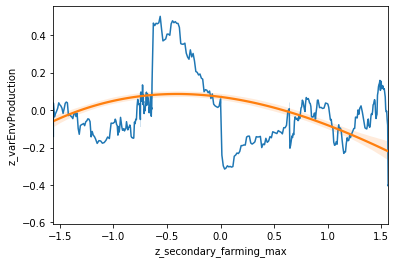

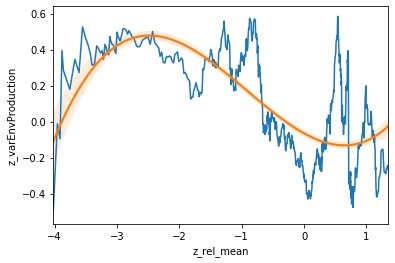

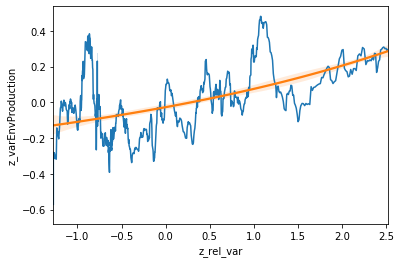

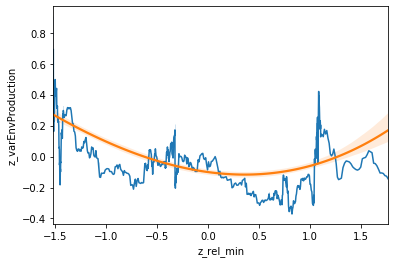

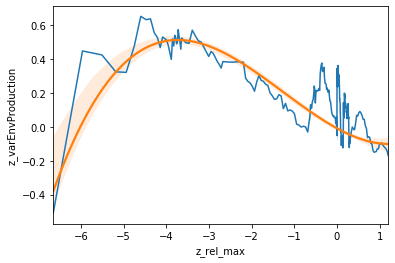

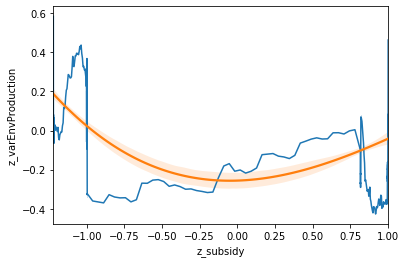

In [27]:
for var in explanatory_var:
    df = data[[var, response_var]].sort_values(by=var).rolling(window=50, min_periods=1).mean()
    sns.lineplot(x=var, y=response_var, data=df)
    sns.regplot(x=var, y=response_var, data=df, fit_reg=True, order=3, scatter=False)
    plt.show()

## Country-wise distributions of explanatory variable

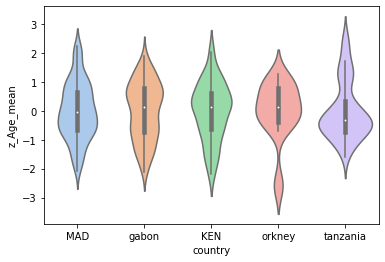

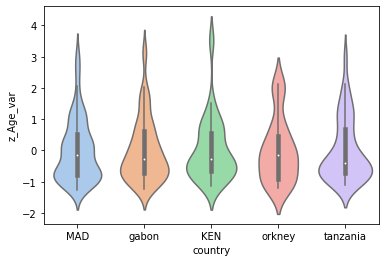

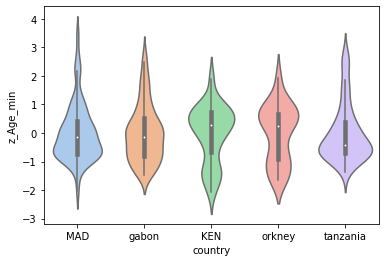

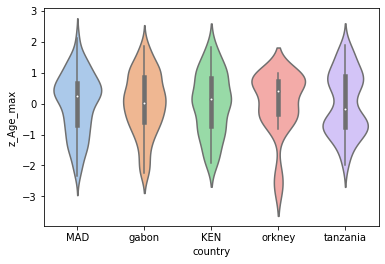

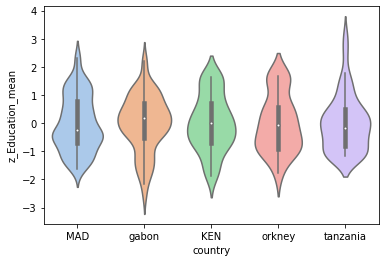

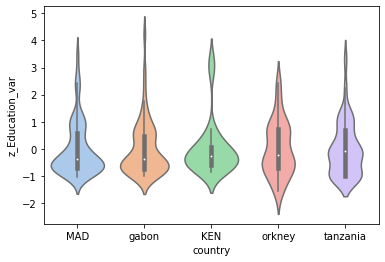

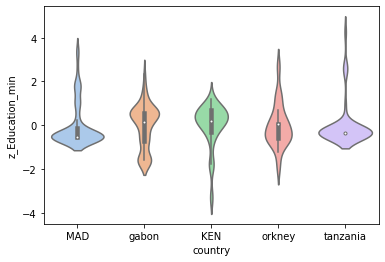

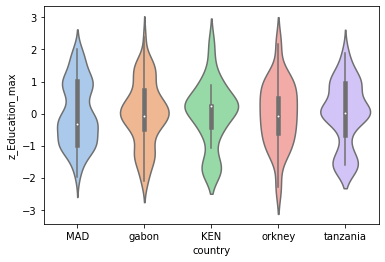

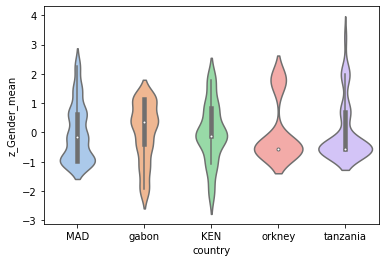

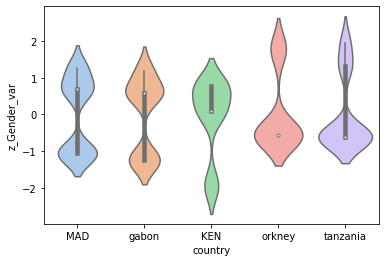

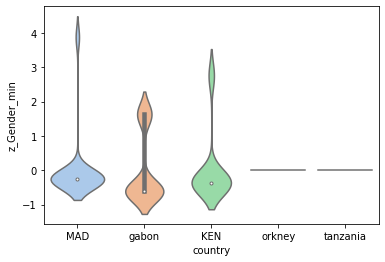

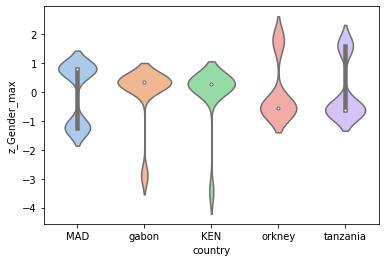

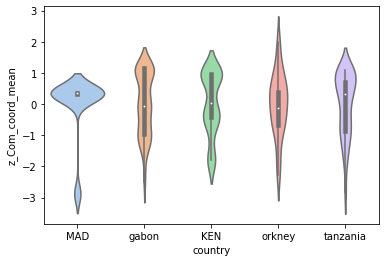

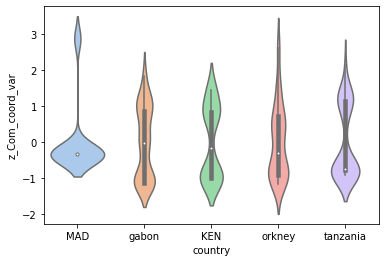

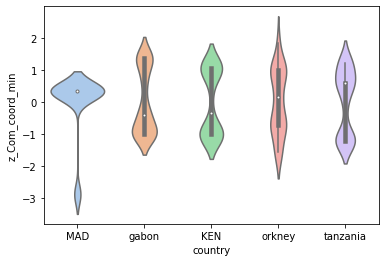

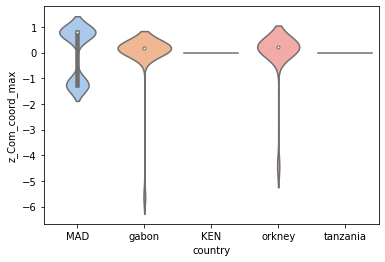

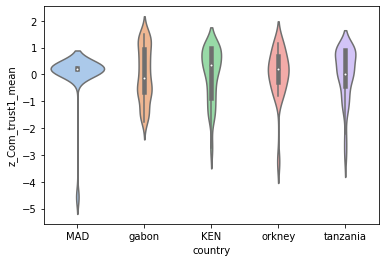

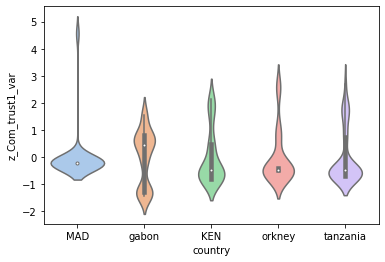

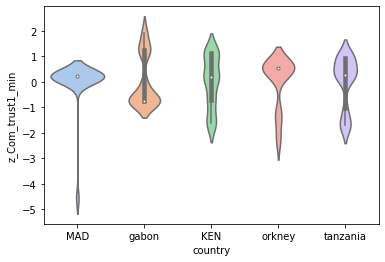

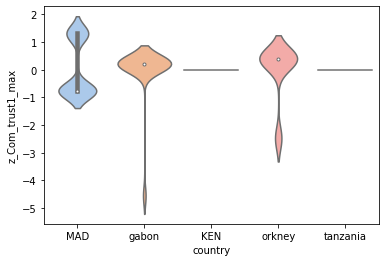

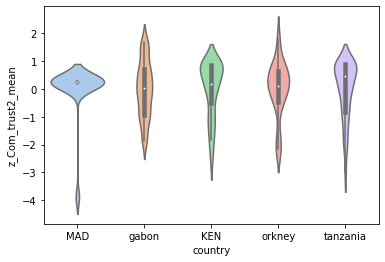

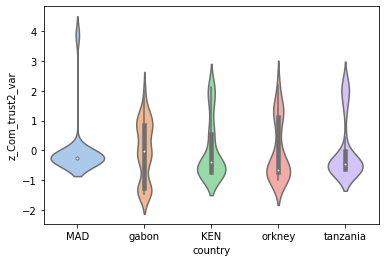

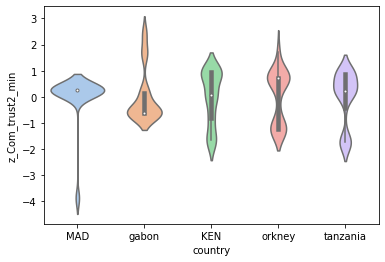

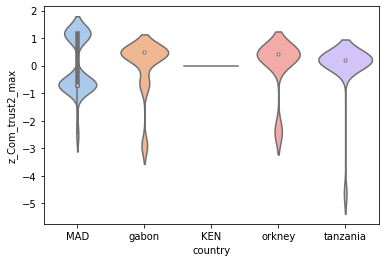

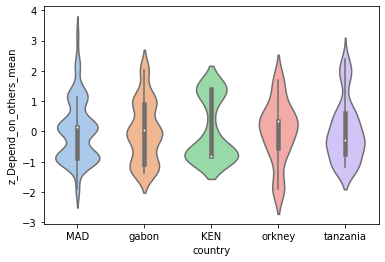

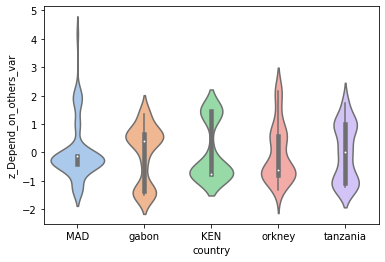

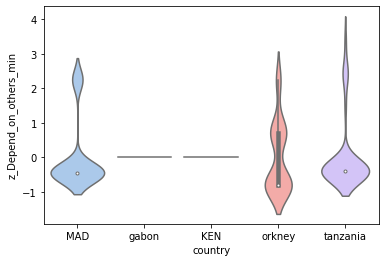

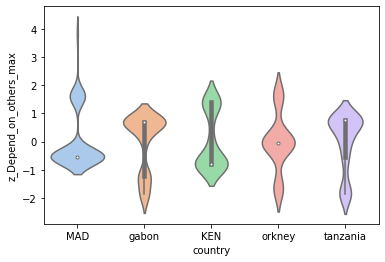

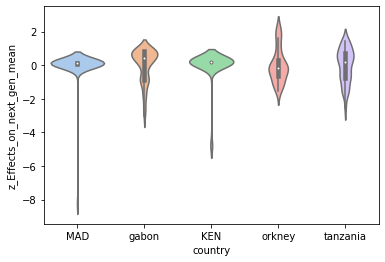

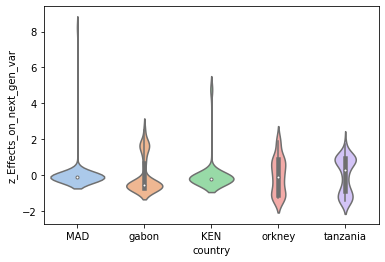

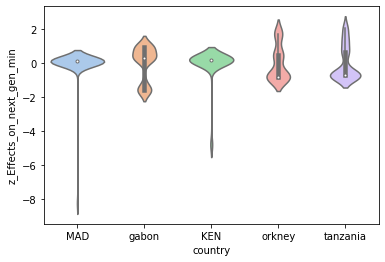

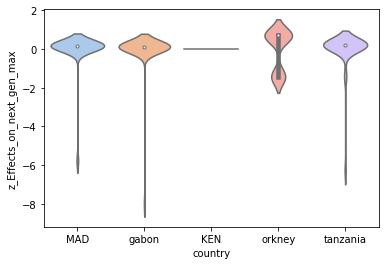

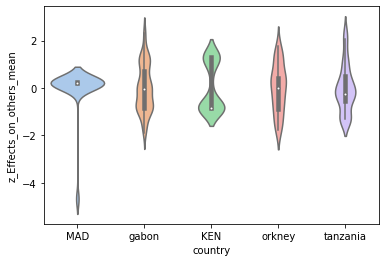

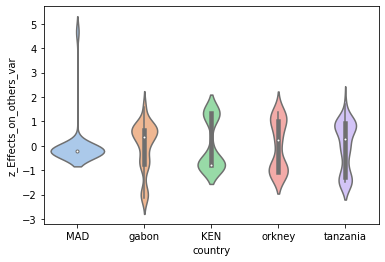

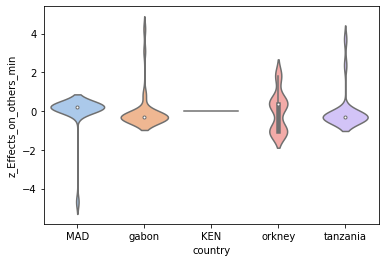

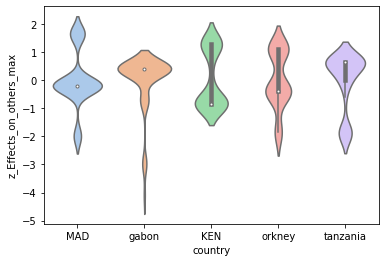

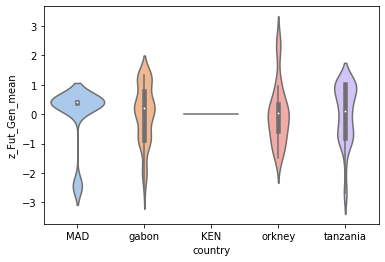

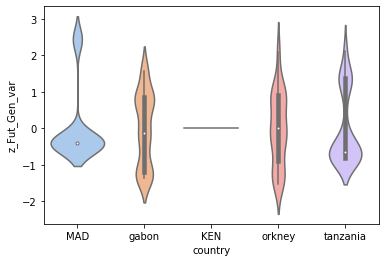

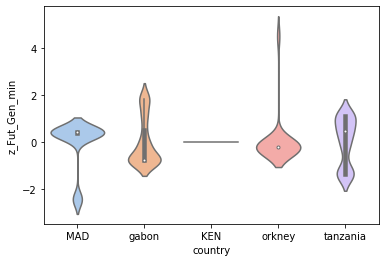

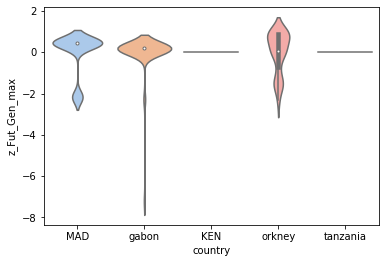

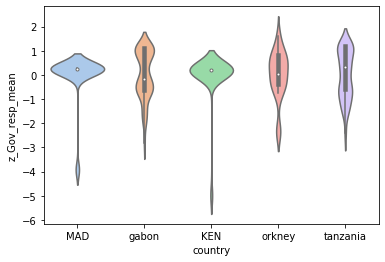

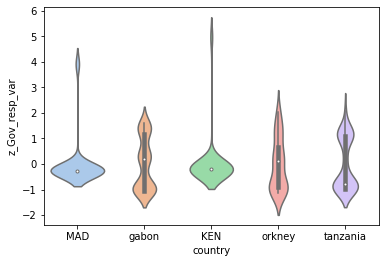

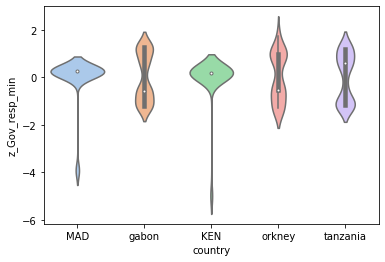

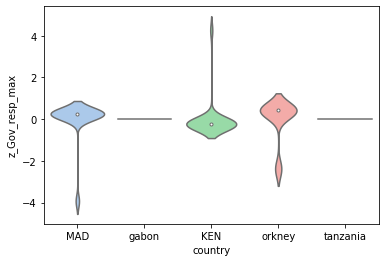

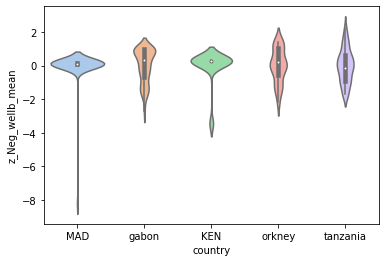

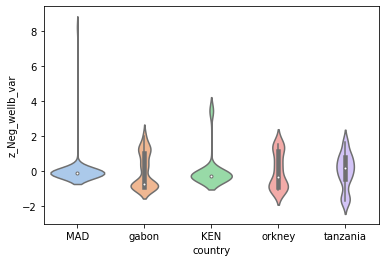

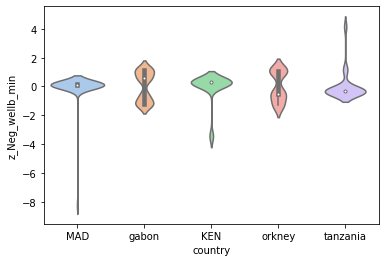

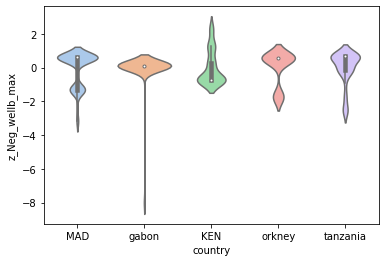

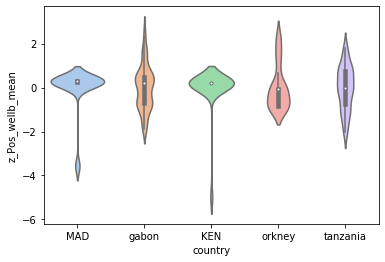

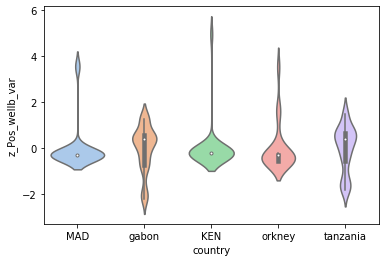

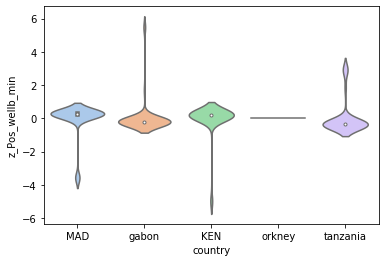

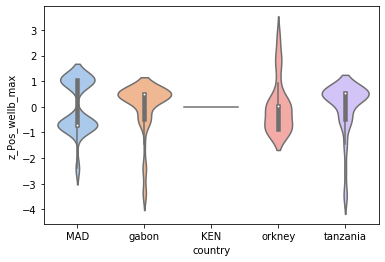

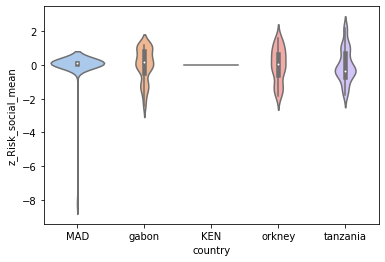

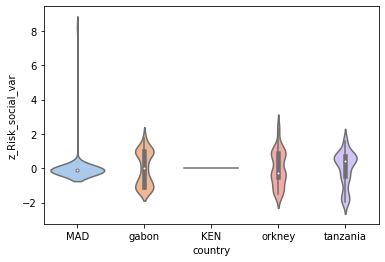

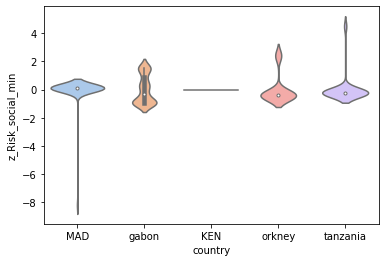

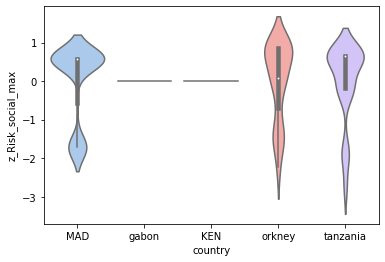

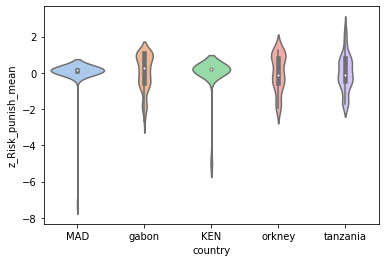

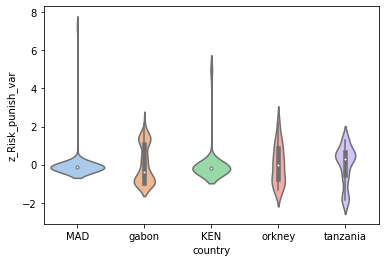

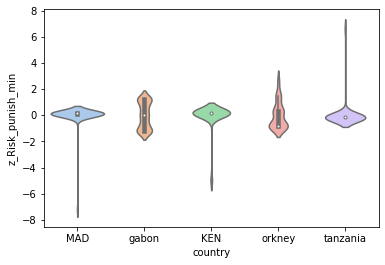

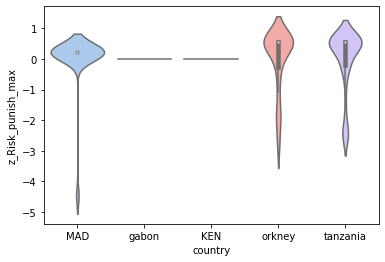

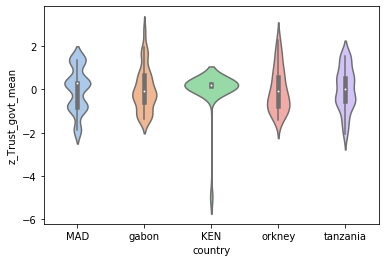

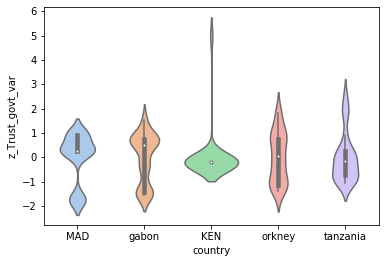

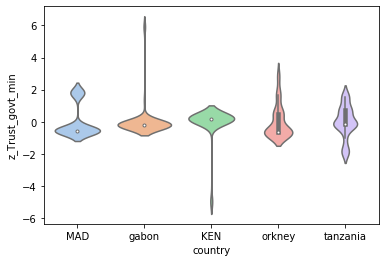

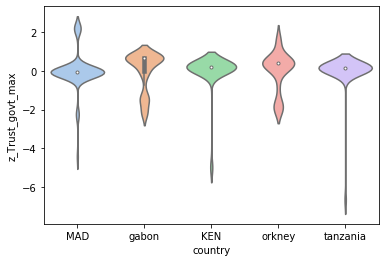

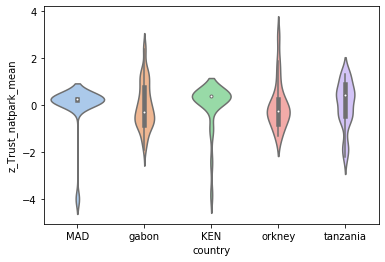

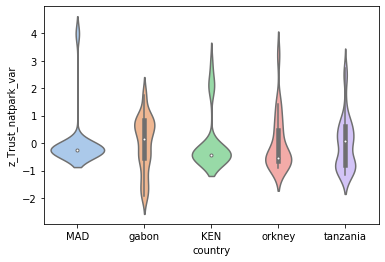

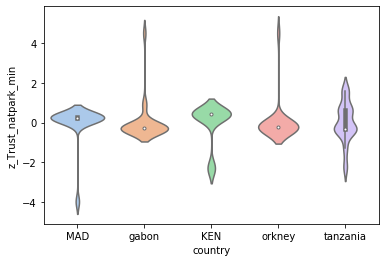

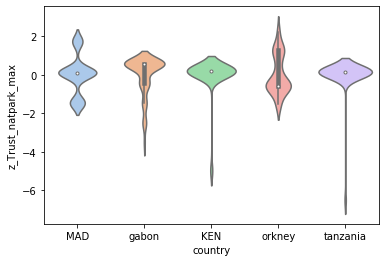

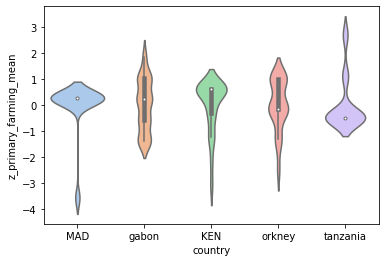

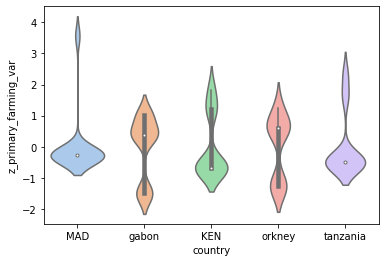

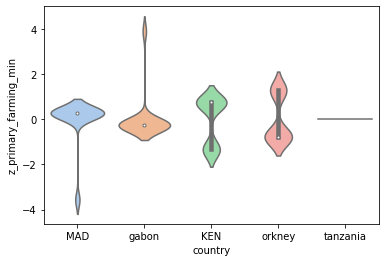

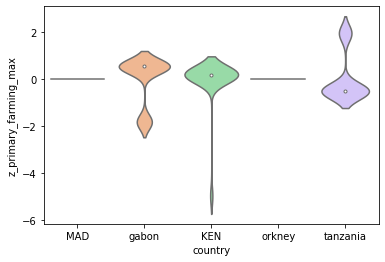

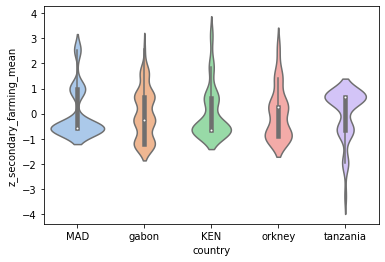

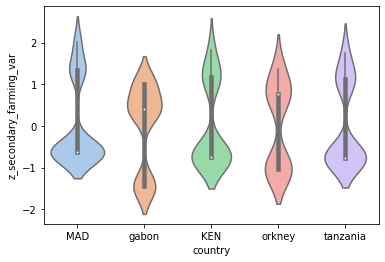

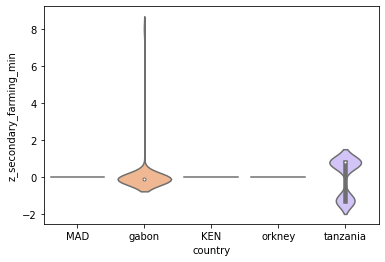

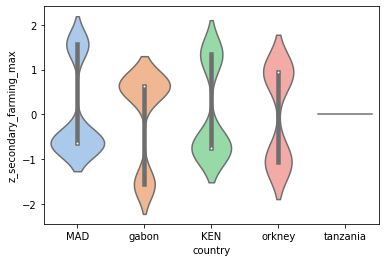

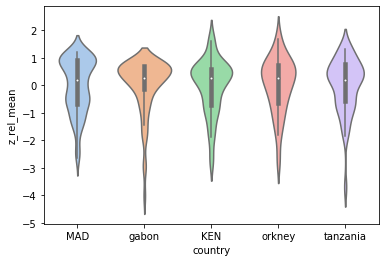

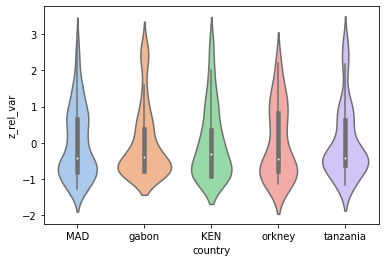

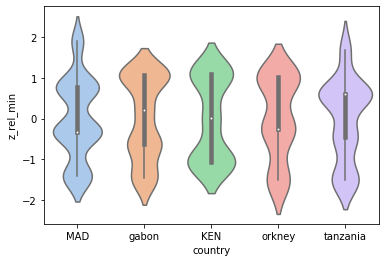

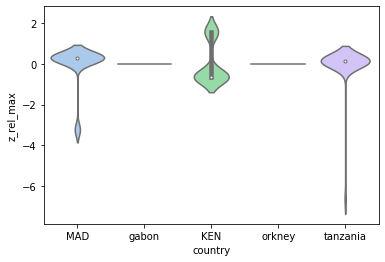

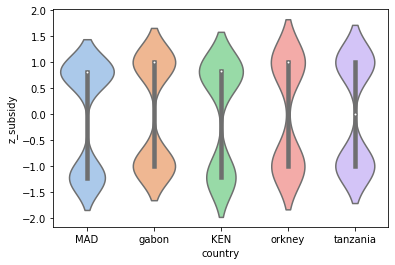

In [28]:
for var in explanatory_var:
    #df = data[[var, 'country']].groupby('country').boxplot(figsize=(12,4), layout=(1,7))
    sns.violinplot('country', var, data=data, palette='pastel')
    plt.show()

In [29]:
"""from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x = StandardScaler().fit_transform(data[explanatory_var])
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf.loc[:, 'principal component 1'],
           principalDf.loc[:, 'principal component 2'],
           c = data[response_var], s = 10, cmap='Blues')
ax.grid()"""

"from sklearn.preprocessing import StandardScaler\nfrom sklearn.decomposition import PCA\n\nx = StandardScaler().fit_transform(data[explanatory_var])\npca = PCA(n_components=2)\nprincipalComponents = pca.fit_transform(x)\nprincipalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])\n\nfig = plt.figure(figsize = (8,8))\nax = fig.add_subplot(1,1,1) \nax.set_xlabel('Principal Component 1', fontsize = 15)\nax.set_ylabel('Principal Component 2', fontsize = 15)\nax.set_title('2 component PCA', fontsize = 20)\nax.scatter(principalDf.loc[:, 'principal component 1'],\n           principalDf.loc[:, 'principal component 2'],\n           c = data[response_var], s = 10, cmap='Blues')\nax.grid()"

In [30]:
"""# calculating beta coefficients from coefficients
beta_coef = []
for var in results.params.index.values[1:]:
    beta_coef.append(results.params[var]*(data[var].std(ddof=0)/data[response_var].std(ddof=0)))
beta_coef = pd.DataFrame({'params':results.params.index.values[1:], 'coefs':beta_coef}).sort_values('coefs', ascending=False)
plt.figure(figsize=(20,5))
plt.bar('params', 'coefs', data=beta_coef)
plt.xticks(rotation=90)
plt.show()"""

"# calculating beta coefficients from coefficients\nbeta_coef = []\nfor var in results.params.index.values[1:]:\n    beta_coef.append(results.params[var]*(data[var].std(ddof=0)/data[response_var].std(ddof=0)))\nbeta_coef = pd.DataFrame({'params':results.params.index.values[1:], 'coefs':beta_coef}).sort_values('coefs', ascending=False)\nplt.figure(figsize=(20,5))\nplt.bar('params', 'coefs', data=beta_coef)\nplt.xticks(rotation=90)\nplt.show()"